In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot, plot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn import linear_model

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb
from sklearn.decomposition import PCA

import xgboost as xgboost
from xgboost import plot_importance

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


# modelling
from scipy import stats
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler


def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.abs((y_true - y_pred) / y_true)) * 100

In [212]:
def visulization(dataset, compares, regions, quarters, title_str):

    for region in regions:
        database = pd.DataFrame()
        for quarter in quarters:
            database = pd.concat([database, dataset[(dataset.GLOBAL_01_CODE==region) & (dataset.CLOSING_QUARTER_ACTUAL==quarter)]]).reset_index(drop=True)

        data = []
        
        for k in compares:
            k = go.Scatter(
                x = list(range(len(database[str(k)]))),
                y = database[str(k)],
                mode = 'lines',
                name = str(k)
                )

            data.append(k)

        if 'SnapDate' in database.columns.values:
            width=1000
            height=600
            labels = database.SnapDate.unique()[::20]
            tickvals=[]
            for i in labels:
                tickvals.append(database[database.SnapDate == str(i)].index.tolist()[0]) 
                
            '''upper = go.Scatter(
                x = list(range(len(database['ACTUAL']))),
                y = database['ACTUAL'].values * 1.1,
                line = dict(color='black', width=4, dash='dash'),
                name = 'upper +10%'
                )

            lower = go.Scatter(
                x = list(range(len(database['ACTUAL']))),
                y = database['ACTUAL'].values * 0.9,
                line = dict(color='black', width=4, dash='dash'),
                name = 'lower -10%'
                )
            
            data.append(upper)
            data.append(lower)'''

        elif 'CLOSING_QUARTER_ACTUAL' in database.columns.values:
            width=1000
            height=400
            labels = database.CLOSING_QUARTER_ACTUAL.unique()
            tickvals=[]
            for i in labels:
                tickvals.append(database[database.CLOSING_QUARTER_ACTUAL == str(i)].index.tolist()[0])

        elif ('SnapDate' not in database.columns.values) and ('CLOSING_QUARTER_ACTUAL' not in database.columns.values):
            fig = go.Figure(data)
            iplot(fig)

        layout = go.Layout(
            title= str(region)  + ' - ' + title_str,

            autosize=False,width=width,height=height,

            xaxis=go.layout.XAxis(
                #title = str(compares),
                tickangle=75,
                ticktext=labels,
                tickvals=tickvals,
                showticklabels=True
            ),
            yaxis= dict(
                overlaying='y',
                side='left',
                showgrid=False,
                showticklabels=True
            )
        )

        fig = go.Figure(data, layout)

        iplot(fig)



In [213]:
df = pd.read_csv('./df_cloud.csv', sep = ';', decimal=',', index_col=0)
model1 = pd.read_csv('./cloud/model1/final_fc.csv', sep = ';', decimal=',', index_col=0)
model1_mape = model1.groupby(['REGION','YEAR_QUARTER']).mean()

In [214]:
df.head(3)

,DATE,REGION,YEAR_QUARTER,PROFIT_CTR,OPEN_COMMIT_VAL,OPEN_COMMIT_COUNT,OPEN_PROBABLE_VAL,OPEN_PROBABLE_COUNT,OPEN_UPSIDE_VAL,OPEN_UPSIDE_COUNT,...,WB_PROBABLE_COUNT,WB_UPSIDE_VAL,WB_UPSIDE_COUNT,VERBAL,ESTIMATED_IN,WON,ADRM,BUDGET,REGION2,ACTUALS
0,2018-01-01,AP,2018-Q1,M171I00070,6359.32335,45.0,49631.32615,385.0,170406.38675,2342.0,...,46.0,9299.58092,70.0,33999.71,0.00000,123.63829,55990.64950,45513.24473,ap,3.948256e+07
1,2018-01-01,EMNORTH,2018-Q1,S237000600,1685.84110,44.0,37053.13588,289.0,149054.15009,1308.0,...,34.0,11788.96354,63.0,26999.76,12.16456,231.30760,38751.14154,34683.70963,emnorth,3.906467e+07
2,2018-01-01,EMSOUTH,2018-Q1,MSIL00MI70,482.49033,7.0,25678.70798,273.0,95050.76179,1142.0,...,35.0,5582.12890,45.0,15599.66,469.27056,0.00000,26630.46887,19915.08873,emsouth,1.804038e+07


In [217]:
model1_mape = pd.read_csv('./cloud/model1/final_quarterly_MAPE.csv', sep = ';', decimal=',', index_col=0)

In [218]:
model1_mape[(model1_mape.YEAR_QUARTER=='2018-Q2')|
    (model1_mape.YEAR_QUARTER=='2018-Q3')| (model1_mape.YEAR_QUARTER=='2018-Q4')|
    (model1_mape.YEAR_QUARTER=='2019-Q1')| (model1_mape.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso    0.187038
MAPE_lr       0.187038
MAPE_rf       0.192542
dtype: float64

In [219]:
df['DV2'] = df['OPEN_COMMIT_VAL'] + df['OPEN_PROBABLE_VAL'] + df['OPEN_UPSIDE_VAL']
df['DV'] = df['ACTUALS'] - df['OPEN_COMMIT_VAL'] - df['OPEN_PROBABLE_VAL'] - df['OPEN_UPSIDE_VAL'] - df['ESTIMATED_IN']

In [ ]:
df['DV'] = df['ACTUALS'] - df['OPEN_COMMIT_VAL'] - df['OPEN_PROBABLE_VAL'] - df['OPEN_UPSIDE_VAL'] - df['ESTIMATED_IN']

In [220]:
df.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'PROFIT_CTR', 'OPEN_COMMIT_VAL',
       'OPEN_COMMIT_COUNT', 'OPEN_PROBABLE_VAL', 'OPEN_PROBABLE_COUNT',
       'OPEN_UPSIDE_VAL', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_VAL',
       'WB_COMMIT_COUNT', 'WB_PROBABLE_VAL', 'WB_PROBABLE_COUNT',
       'WB_UPSIDE_VAL', 'WB_UPSIDE_COUNT', 'VERBAL', 'ESTIMATED_IN', 'WON',
       'ADRM', 'BUDGET', 'REGION2', 'ACTUALS', 'DV2', 'DV'],
      dtype='object')

In [222]:
df_cloud = df.loc[:,['DATE', 'REGION', 'YEAR_QUARTER','OPEN_COMMIT_VAL','OPEN_PROBABLE_VAL','OPEN_UPSIDE_VAL',
                     'OPEN_COMMIT_COUNT','OPEN_PROBABLE_COUNT','OPEN_UPSIDE_COUNT', 
                     'WB_COMMIT_COUNT','WB_PROBABLE_COUNT','WB_UPSIDE_COUNT',
                    'DV2', 'DV', 'ESTIMATED_IN','BUDGET','VERBAL','ACTUAL']]

In [223]:
df_cloud = df_cloud.sort_values(by=['YEAR_QUARTER','REGION']).reset_index(drop=True)

In [224]:
df_cloud = pd.merge(df_cloud, model1[['DATE', 'REGION', 'YEAR_QUARTER', 'lr_Pred', 'lasso_Pred', 'rf_Pred', 'MAPE_lasso', 'MAPE_lr', 'MAPE_rf']], 
                     on = ['YEAR_QUARTER', 'REGION', 'DATE'], how = 'inner')



# Handling time dimensions
### calculate day in quarter
###### some quarter have different durations - I need to ensure that the last days in the quarter match when joining historic data. Missing values for the first day will then simply be filled with the subsequent day

In [225]:
days = df_cloud[['DATE', 'YEAR_QUARTER']].drop_duplicates()

days['DayInQuarter'] = days.sort_values(['DATE'], ascending=[False]).groupby(['YEAR_QUARTER']).cumcount() + 1
days['DayInQuarter_asc'] = days.sort_values(['DATE'], ascending=[True]).groupby(['YEAR_QUARTER']).cumcount() + 1

In [226]:
df_cloud = pd.merge(df_cloud, days[['DATE', 'DayInQuarter', 'DayInQuarter_asc']], on = 'DATE', how = 'left')

### calculate index for quarter
###### having a running index for quarter will help calculate rolling snapshots

In [227]:
quarter = df_cloud[['YEAR_QUARTER']].drop_duplicates()

quarter['QuarterIndex'] = quarter.sort_values(['YEAR_QUARTER'], ascending=[True]).reset_index().index

quarter['QuarterIndex'] = quarter['QuarterIndex'] + 1

In [228]:
df_cloud = pd.merge(df_cloud, quarter[['YEAR_QUARTER', 'QuarterIndex']], on = 'YEAR_QUARTER', how = 'left')

# Fixing Data issues
###### the first two weeks of Q1 2019 contains incorrect values for budget - replacing them with values from day 15

In [229]:
#BudgetFix = df_cloud.loc[(df_cloud['YEAR_QUARTER'] == "2019-Q1")  & (df_subset['DayInQuarter_asc'] == 15), :]
#BudgetFix['BudgetFix'] = BudgetFix['BUDGET']

In [230]:
'''
df_cloud = pd.merge(df_subset, BudgetFix[['GLOBAL_01_CODE', 'QuarterIndex', 'BudgetFix']], 
                on = ['GLOBAL_01_CODE', 'QuarterIndex'], how = 'left')

df_cloud.loc[(df_subset.DayInQuarter_asc < 15) & (df_subset.CLOSING_QUARTER_ACTUAL == "2019-Q1"), 'BUDGET'] = df_subset['BudgetFix']

df_subset = df_subset.drop("BudgetFix", axis=1)
'''

'\ndf_cloud = pd.merge(df_subset, BudgetFix[[\'GLOBAL_01_CODE\', \'QuarterIndex\', \'BudgetFix\']], \n                on = [\'GLOBAL_01_CODE\', \'QuarterIndex\'], how = \'left\')\n\ndf_cloud.loc[(df_subset.DayInQuarter_asc < 15) & (df_subset.CLOSING_QUARTER_ACTUAL == "2019-Q1"), \'BUDGET\'] = df_subset[\'BudgetFix\']\n\ndf_subset = df_subset.drop("BudgetFix", axis=1)\n'

## <font color='red'>Manipulate Quarter Index to "bootstrap" - swapping the holdout sample.<font>

In [231]:
#df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2018-Q1', 'QuarterIndex'] = 1
#df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2019-Q1', 'QuarterIndex'] = 5

# creation of Analytical dataset

#### Initiating dataset by selecting straightforward entries first (time dimensions, dependent variable, Estimated In, Open Pipe)

In [232]:
#df_subset['DV2'] = df_subset.CurrentQuarter_Commit + df_subset.CurrentQuarterProbable + df_subset.CurrentQuarter_Upside

# Exploratory Analysis

### Opportunities with a qualification status of upside / probable show a different closing probability throughout the quarter. To account for this teh open opportunity value need to be adjusted.

In [233]:
df_cloud.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'OPEN_COMMIT_VAL',
       'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 'OPEN_COMMIT_COUNT',
       'OPEN_PROBABLE_COUNT', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_COUNT',
       'WB_PROBABLE_COUNT', 'WB_UPSIDE_COUNT', 'DV2', 'DV', 'ESTIMATED_IN',
       'BUDGET', 'VERBAL', 'ACTUAL', 'lr_Pred', 'lasso_Pred', 'rf_Pred',
       'MAPE_lasso', 'MAPE_lr', 'MAPE_rf', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex'],
      dtype='object')

In [234]:
#dummy = df_cloud[df_cloud.QuarterIndex < 5].copy(deep=True)
dummy = df_cloud.copy(deep=True)

dummy.loc[dummy.DayInQuarter > 90, 'DayInQuarter'] = 90

'''dummy = dummy[['REGION', 'DayInQuarter', 'Count_Open_AB', 'Count_Open_CD', 'Count_Open_EF', 'Count_Open_Commit', 'Count_Open_Probable', 'Count_Open_Upside',
               'Count_AB', 'Count_CD', 'Count_EF', 'Count_Commit', 'Count_Probable', 'Count_Upside',
               'Open_Commit', 'Open_Probable', 'Open_Upside', 'CurrentQuarter_Commit', 'CurrentQuarterProbable', 'CurrentQuarter_Upside']]'''

dummy['FactorCommit'] = dummy['WB_COMMIT_COUNT'] / dummy['OPEN_COMMIT_COUNT']
dummy['FactorProbable'] = dummy['WB_PROBABLE_COUNT'] / dummy['OPEN_PROBABLE_COUNT']
dummy['FactorUpside'] = dummy['WB_UPSIDE_COUNT'] / dummy['OPEN_UPSIDE_COUNT']

ClosingRates = dummy[['REGION', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']]

ClosingRates = dummy.groupby(by = ['REGION', 'DayInQuarter']).mean().reset_index()


### <font color='red'>This step, we get the value 'OpenPipe_adj', which we used input variable 'WeightedPipe' later!!<font>

In [235]:
df_cloud = pd.merge(df_cloud, ClosingRates[['REGION', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']], 
                on = ['REGION', 'DayInQuarter'], how = 'left')

df_cloud['Open_Commit_adj'] = df_cloud['OPEN_COMMIT_VAL'] * df_cloud['FactorCommit']
df_cloud['Open_Probable_adj'] = df_cloud['OPEN_PROBABLE_VAL'] * df_cloud['FactorProbable']
df_cloud['Open_Upside_adj'] = df_cloud['OPEN_UPSIDE_VAL'] * df_cloud['FactorUpside']
df_cloud['OpenPipe_adj'] = df_cloud['Open_Upside_adj'] + df_cloud['Open_Probable_adj'] + df_cloud['Open_Commit_adj']

df_cloud['OpenPipe_adj'] = df_cloud['OpenPipe_adj'].astype(float)

In [236]:
df_cloud.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'OPEN_COMMIT_VAL',
       'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 'OPEN_COMMIT_COUNT',
       'OPEN_PROBABLE_COUNT', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_COUNT',
       'WB_PROBABLE_COUNT', 'WB_UPSIDE_COUNT', 'DV2', 'DV', 'ESTIMATED_IN',
       'BUDGET', 'VERBAL', 'ACTUAL', 'lr_Pred', 'lasso_Pred', 'rf_Pred',
       'MAPE_lasso', 'MAPE_lr', 'MAPE_rf', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'FactorCommit', 'FactorProbable', 'FactorUpside',
       'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj',
       'OpenPipe_adj'],
      dtype='object')

In [237]:
ad_1 = df_cloud[['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex',
                 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 
                 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj', 
                 'ESTIMATED_IN', 'BUDGET', 'VERBAL', 'ACTUAL', 'DV2', 'DV',
                 'lr_Pred', 'lasso_Pred', 'rf_Pred', 'MAPE_lasso', 'MAPE_lr', 'MAPE_rf']]

### Linearity based on last quarter

In [238]:
dummy0 = ad_1 #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy1 = dummy0.copy(deep=True)

dummy1['QuarterIndex'] = dummy1['QuarterIndex'] + 1
dummy1['ESTIMATED_IN_tm1'] = dummy1['ESTIMATED_IN']
dummy1['DV_tm1'] = dummy1['DV2']
dummy1['BUDGET_tm1'] = dummy1['BUDGET']

dummy0 = pd.merge(dummy0, dummy1[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm1', 'DV_tm1', 'BUDGET_tm1']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')


In [239]:
dummy0['Linearity_EstIn_1Q'] = dummy0.DV_tm1 / dummy0.ESTIMATED_IN_tm1
dummy0['Linearity_Budget_1Q'] = dummy0.DV_tm1 / dummy0.BUDGET_tm1

In [240]:
ad_2 = pd.merge(ad_1, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 2

In [241]:
dummy0 = ad_1 #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy2 = dummy0.copy(deep=True)

dummy2['QuarterIndex'] = dummy2['QuarterIndex'] + 2
dummy2['ESTIMATED_IN_tm2'] = dummy2['ESTIMATED_IN']
dummy2['DV_tm2'] = dummy2['DV2']
dummy2['BUDGET_tm2'] = dummy2['BUDGET']

dummy0 = pd.merge(dummy0, dummy2[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm2', 'DV_tm2', 'BUDGET_tm2']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [242]:
dummy0['Linearity_EstIn_2Q'] = dummy0.DV_tm2 / dummy0.ESTIMATED_IN_tm2
dummy0['Linearity_Budget_2Q'] = dummy0.DV_tm2 / dummy0.BUDGET_tm2

In [243]:
ad_3 = pd.merge(ad_2, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_2Q', 'Linearity_Budget_2Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 3

In [244]:
dummy0 = ad_1  #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy3 = dummy0.copy(deep=True)

dummy3['QuarterIndex'] = dummy3['QuarterIndex'] + 3
dummy3['ESTIMATED_IN_tm3'] = dummy3['ESTIMATED_IN']
dummy3['DV_tm3'] = dummy3['DV2']
dummy3['BUDGET_tm3'] = dummy3['BUDGET']

dummy0 = pd.merge(dummy0, dummy3[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm3', 'DV_tm3', 'BUDGET_tm3']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [245]:
dummy0['Linearity_EstIn_3Q'] = dummy0.DV_tm3 / dummy0.ESTIMATED_IN_tm3
dummy0['Linearity_Budget_3Q'] = dummy0.DV_tm3 / dummy0.BUDGET_tm3

In [246]:
ad_4 = pd.merge(ad_3, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_3Q', 'Linearity_Budget_3Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 4

In [247]:
dummy0 = ad_1  #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy4 = dummy0.copy(deep=True)

dummy4['QuarterIndex'] = dummy4['QuarterIndex'] + 4
dummy4['ESTIMATED_IN_tm4'] = dummy4['ESTIMATED_IN']
dummy4['DV_tm4'] = dummy4['DV2']
dummy4['BUDGET_tm4'] = dummy4['BUDGET']

dummy0 = pd.merge(dummy0, dummy4[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm4', 'DV_tm4', 'BUDGET_tm4']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [248]:
dummy0['Linearity_EstIn_4Q'] = dummy0.DV_tm4 / dummy0.ESTIMATED_IN_tm4
dummy0['Linearity_Budget_4Q'] = dummy0.DV_tm4 / dummy0.BUDGET_tm4

In [249]:
ad_5 = pd.merge(ad_4, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_4Q', 'Linearity_Budget_4Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### build rolling average
#### historic quarter are not necessarily availble. Thus a rolling average is only build based on available data by replacing missing values with 0 and then count non zeros for average creation

In [250]:
# replacing missing values

ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_2Q"]) == True, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_3Q"]) == True, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_4Q"]) == True, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[pd.isnull(ad_5["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_2Q"]) == True, 'Linearity_Budget_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_3Q"]) == True, 'Linearity_Budget_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_4Q"]) == True, 'Linearity_Budget_4Q'] = 0

ad_5.loc[ad_5.Linearity_EstIn_1Q < 0, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_2Q < 0, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_3Q < 0, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_4Q < 0, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[ad_5.Linearity_Budget_1Q < 0, 'Linearity_Budget_1Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_2Q < 0, 'Linearity_Budget_2Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_3Q < 0, 'Linearity_Budget_3Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_4Q < 0, 'Linearity_Budget_4Q'] = 0

# count populated entries

ad_5['LinearityEstIn_Counter'] = 0
ad_5['LinearityBudget_Counter'] = 0


ad_5.loc[ad_5.Linearity_EstIn_1Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter'] + 1
ad_5.loc[ad_5.Linearity_EstIn_2Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_3Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_4Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1

ad_5.loc[ad_5.Linearity_Budget_1Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_2Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_3Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_4Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1


# rolling average

ad_5['LinearityEstIn_rolling'] =0
ad_5['LinearityBudget_rolling'] = 0

ad_5['LinearityEstIn_rolling'] = (ad_5['Linearity_EstIn_1Q'] + 
                                 ad_5['Linearity_EstIn_2Q'] +
                                 ad_5['Linearity_EstIn_3Q'] +
                                 ad_5['Linearity_EstIn_4Q']) / ad_5['LinearityEstIn_Counter'] * ad_5['ESTIMATED_IN']
ad_5['LinearityBudget_rolling'] = (ad_5['Linearity_Budget_1Q'] + 
                                 ad_5['Linearity_Budget_2Q'] +
                                 ad_5['Linearity_Budget_3Q'] +
                                 ad_5['Linearity_Budget_4Q']) / ad_5['LinearityBudget_Counter'] * ad_5['BUDGET']

### add delta EstIn / OpenPipe
#### calculating the difference between two snapshots to be used as an independent variable

In [251]:
dummy0 = ad_1  #df_cloud[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN']]
dummy1 = dummy0.copy(deep=True)

dummy1['DayInQuarter_asc'] = dummy1['DayInQuarter_asc'] + 1
dummy1['ESTIMATED_IN_dm1'] = dummy1['ESTIMATED_IN']
#dummy1['OpenPipe_dm1'] = dummy1['OpenPipe']

dummy0 = pd.merge(dummy0, dummy1[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN_dm1']], 
                  on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

In [252]:
dummy0['Delta_EstIn'] = dummy0.ESTIMATED_IN - dummy0.ESTIMATED_IN_dm1 
#dummy0['Delta_OpenPipe'] = dummy0.OpenPipe - dummy0.OpenPipe_dm1 

In [253]:
ad_6 = pd.merge(ad_5, dummy0[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'Delta_EstIn']], 
                on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

In [254]:
ad_6['Estimated_Gap'] = ad_6['BUDGET'] - ad_6['ESTIMATED_IN'] - ad_6['OpenPipe_adj']
# ad_6['Estimated_Gap'] = ad_6['BUDGET'] - ad_6['ESTIMATED_IN'] - ad_6['MLP']

ad_6.loc[ad_6.Estimated_Gap < 0, 'Estimated_Gap'] = 0

# Final Variable Selection

In [255]:
ad_6.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL',
       'OPEN_UPSIDE_VAL', 'Open_Commit_adj', 'Open_Probable_adj',
       'Open_Upside_adj', 'OpenPipe_adj', 'ESTIMATED_IN', 'BUDGET', 'VERBAL',
       'ACTUAL', 'DV2', 'DV', 'lr_Pred', 'lasso_Pred', 'rf_Pred', 'MAPE_lasso',
       'MAPE_lr', 'MAPE_rf', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'Linearity_EstIn_2Q', 'Linearity_Budget_2Q', 'Linearity_EstIn_3Q',
       'Linearity_Budget_3Q', 'Linearity_EstIn_4Q', 'Linearity_Budget_4Q',
       'LinearityEstIn_Counter', 'LinearityBudget_Counter',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn',
       'Estimated_Gap'],
      dtype='object')

In [257]:
AnalyticalData = ad_6[['DATE', 'REGION', 'YEAR_QUARTER',
                      'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex',
                      'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL',
                      'DV2', 'DV', 'BUDGET', 'ESTIMATED_IN',
                      'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
                      'Linearity_EstIn_1Q',
                      'Linearity_Budget_1Q',
                      'LinearityEstIn_rolling',
                      'LinearityBudget_rolling',
                      'Delta_EstIn',
                      'lasso_Pred']]

AnalyticalData['Linearity_EstIn_1Q'] = AnalyticalData['Linearity_EstIn_1Q'] * AnalyticalData['ESTIMATED_IN']
AnalyticalData['Linearity_Budget_1Q'] = AnalyticalData['Linearity_Budget_1Q'] * AnalyticalData['BUDGET']

AnalyticalData = AnalyticalData.replace([np.inf, -np.inf], np.nan)

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### not all quarter have the same amount of days - in these cases missing values for independet variables can occur and are replaced with data from the following day. This data would be available given that the Analytical dataset contains only historic data resp. derivates from historic data
###### populate day 2 with day 3

In [258]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 3,
    ['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
#dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5']], 
                  on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_EstIn'] = AnalyticalData['fix5']
#AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
#                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
#AnalyticalData = AnalyticalData.drop("fix6", axis=1)

###### populate day 1 with day 2

In [259]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 2,
    ['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
#dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5']], 
                  on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_EstIn'] = AnalyticalData['fix5']
#AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
#                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
#AnalyticalData = AnalyticalData.drop("fix6", axis=1)

###### populate remaining missing values

In [260]:
AnalyticalData.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL',
       'OPEN_UPSIDE_VAL', 'DV2', 'DV', 'BUDGET', 'ESTIMATED_IN',
       'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj',
       'OpenPipe_adj', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn',
       'lasso_Pred'],
      dtype='object')

In [261]:
AnalyticalData.loc[pd.isnull(AnalyticalData["ESTIMATED_IN"]) == True, 'ESTIMATED_IN'] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe"]) == True, "OpenPipe"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe_adj"]) == True, "OpenPipe_adj"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_AB"]) == True, "Open_AB"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_CD"]) == True, "Open_CD"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_EF"]) == True, "Open_EF"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Commit_adj"]) == True, "Open_Commit_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Probable_adj"]) == True, "Open_Probable_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Upside_adj"]) == True, "Open_Upside_adj"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Commit"]) == True, "Open_Commit"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Probable"]) == True, "Open_Probable"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Upside"]) == True, "Open_Upside"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True, 'LinearityEstIn_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True, 'LinearityBudget_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_EstIn"]) == True, 'Delta_EstIn'] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True, 'Delta_OpenPipe'] = 0

AnalyticalData.loc[pd.isnull(AnalyticalData["BUDGET"]) == True, 'BUDGET'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OPEN_COMMIT_VAL"]) == True, 'OPEN_COMMIT_VAL'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OPEN_PROBABLE_VAL"]) == True, 'OPEN_PROBABLE_VAL'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OPEN_UPSIDE_VAL"]) == True, 'OPEN_UPSIDE_VAL'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["lasso_Pred"]) == True, 'OPEN_UPSIDE_VAL'] = 0

### There are outliers in the data - thus the independent variables which represents estimator of the depnedent variable get limited to a corridor between 
#### upper limit: 60% of budget on day 1 to 30% of budget on day 90
#### lower limit: 30% of budget on day 1 to 0% of budget on day 90

### <font color='red'> Here how to limit the data within the LowerBoundary and UpperBoundary？？？<font>

In [262]:
'''
AnalyticalData['UpperBoundary'] = AnalyticalData['BUDGET'] * 0.6 - (AnalyticalData['BUDGET'] * 0.6 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 180))
AnalyticalData['LowerBoundary'] = AnalyticalData['BUDGET'] * 0.3 - (AnalyticalData['BUDGET'] * 0.3 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 90))

AnalyticalData.loc[AnalyticalData.UpperBoundary < 0, 'UpperBoundary'] = 0
AnalyticalData.loc[AnalyticalData.LowerBoundary < 0, 'LowerBoundary'] = 0

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.UpperBoundary

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.LowerBoundary
'''

"\nAnalyticalData['UpperBoundary'] = AnalyticalData['BUDGET'] * 0.6 - (AnalyticalData['BUDGET'] * 0.6 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 180))\nAnalyticalData['LowerBoundary'] = AnalyticalData['BUDGET'] * 0.3 - (AnalyticalData['BUDGET'] * 0.3 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 90))\n\nAnalyticalData.loc[AnalyticalData.UpperBoundary < 0, 'UpperBoundary'] = 0\nAnalyticalData.loc[AnalyticalData.LowerBoundary < 0, 'LowerBoundary'] = 0\n\nAnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q > AnalyticalData.UpperBoundary, \n                   'Linearity_Budget_1Q'] = AnalyticalData.UpperBoundary\nAnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q > AnalyticalData.UpperBoundary, \n                   'Linearity_EstIn_1Q'] = AnalyticalData.UpperBoundary\nAnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling > AnalyticalData.UpperBoundary, \n                   'LinearityEstIn_rolling'] = AnalyticalData.UpperBoundary\nAnalyticalData.loc[AnalyticalData.LinearityBudget_

In [93]:
# AnalyticalData.to_csv("/Users/i513088/Desktop/Final-model/AnalyticalData_model1_CountQualification.csv")

# AnalyticalData = pd.read_csv("/Users/i513088/Desktop/Final-model/AnalyticalData_model1_CountQualification.csv")

In [264]:
#AnalyticalData.to_csv("./AnalyticalData-mod2.csv", sep = ';', decimal=',')

# ------------------------------------------
# MODELING
# ------------------------------------------

In [265]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [266]:
def train_model(model, param_grid, X=[], y=[], eval_set=[]):
        
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, verbose=0)

    gsearch.fit(X,y)

    # extract best model from the grid
    model = gsearch.best_estimator_        
    best_idx = gsearch.best_index_


    y_train_pred = model.predict(X)
    
    #joblib.dump(model, '/Users/i513088/Desktop/'+'count_'+str(model)[:20]+'.pkl')
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('Train MAPE:',np.mean(MAPE(y_train_pred, y)))
    
    return model


def model_predict(model, x_test,y_test):
    
    y_predict = model.predict(x_test)

    mape = np.mean(MAPE(y_predict, y_test))
    
    #y_pred_model1[model] = pd.Series(y_predict)
    
    #y_pred_model1[str(model)+'mape'] = pd.Series(MAPE(y_predict, y_test))
    
    #y_pred_model1.to_csv('/Users/i513088/Desktop/y_pred_model1-q7.csv')

    print('The model',model, 'test mape is:', mape)
    print('Finished!')

    return y_predict
    

#### creating datasets

In [267]:
AnalyticalData.YEAR_QUARTER.unique()

array(['2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1', '2019-Q2',
       '2019-Q3'], dtype=object)

In [268]:
AnalyticalData.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL',
       'OPEN_UPSIDE_VAL', 'DV2', 'DV', 'BUDGET', 'ESTIMATED_IN',
       'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj',
       'OpenPipe_adj', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn',
       'lasso_Pred'],
      dtype='object')

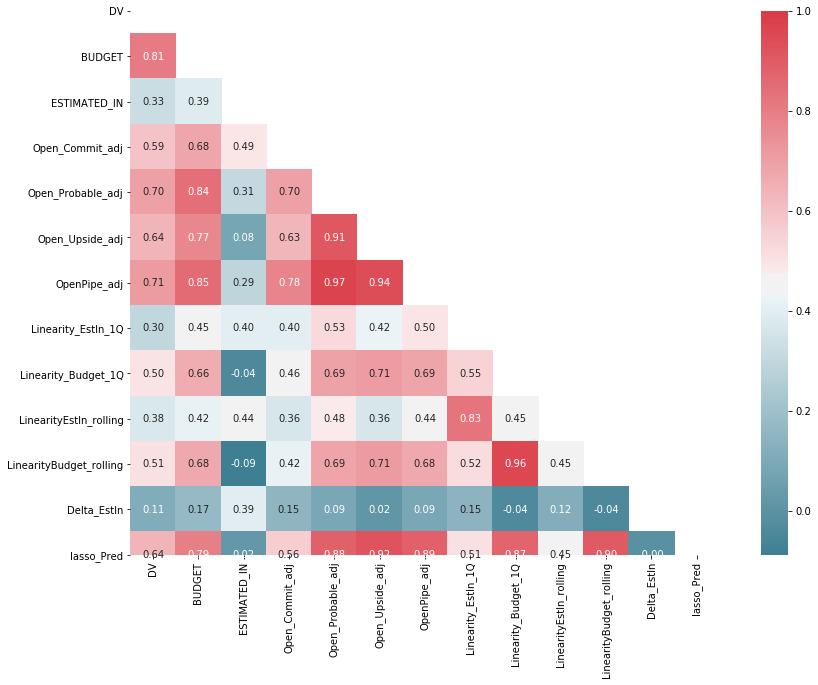

In [269]:
features = AnalyticalData.loc[: , 'DV' : 'lasso_Pred']
#features = pd.concat([features, AnalyticalData['DV2']], axis=1)

plt.figure(figsize=(15, 10))  
colnm = features.columns.tolist()
mcorr = features[colnm].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()


In [313]:
for quarter in list(AnalyticalData.QuarterIndex.unique()):
        
    train = AnalyticalData[(AnalyticalData.QuarterIndex != quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)
    holdout = AnalyticalData[(AnalyticalData.QuarterIndex == quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)

    train_x=train.loc[: , ['ESTIMATED_IN', 
         'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn', 
         'lasso_Pred']]
    train_y=train.DV

    test_x=holdout.loc[: , [#'ESTIMATED_IN', 
         #'Open_Commit_adj', 
         #'Open_Probable_adj', 
         #'Open_Upside_adj', 
         'OpenPipe_adj',
         #'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         #'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         #'Delta_EstIn', 
         'lasso_Pred']]
    test_y=holdout.DV
    
    
    X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.15)
    

    model_name = 'Linear'
    model = linear_model.LinearRegression()
    fit_intercept = [False]
    param_grid = {'fit_intercept': fit_intercept}
    LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
    LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
    LinearReg_coef = LinearReg.coef_


    model_name = 'Lasso'
    model = Lasso()
    fit_intercept = [False]
    alph_range = np.arange(0.1,6,0.25)
    param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
    LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
    LassoReg_coef = LassoReg.coef_
    LassoReg_Pred = model_predict(LassoReg,test_x,test_y)


    model_name = 'RandomForest'
    model = RandomForestRegressor()
    param_grid = {'n_estimators':[100,150,200],
                  'min_samples_split':[2,4,6]
                 }
    RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

    RF_Pred = model_predict(RF,test_x,test_y)


    result = pd.DataFrame({'DATE':holdout.DATE, 'REGION':holdout.REGION,'YEAR_QUARTER':holdout.YEAR_QUARTER,
                   'DV':holdout.DV,'lr_Pred':LinearReg_Pred,'lasso_Pred':LassoReg_Pred,'rf_Pred':RF_Pred})

    result.to_csv('./q' + str(quarter) + '.csv', index = None, header=True, sep=';', decimal=',')


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.69384677772299e+17, tolerance: 1202390536833846.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1301231508274528e+18, tolerance: 1263708801790527.2

/Users/i513088/a

----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 658.5531723425457
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 369.78807145986224
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.693692826905082e+17, tolerance: 1202390536833846.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.086930310913395e+18, tolerance: 1263708801790527.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0533339020334552e+18, tolerance: 1245914448959466.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.693269481042157e+17, tolerance: 1202390536833846.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.801525275125128e+17, tolerance: 1263708801790527.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.597406170949153e+17, tolerance: 1245914448959466.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 658.5531054891115
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 369.7880705308134
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0104392323150081e+18, tolerance: 1034957584236750.9



----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 213.29291220937924
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 182.81310688284825
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.572415326353234e+17, tolerance: 1135068720254636.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.978098846666688e+17, tolerance: 1116420130897425.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0091225178584859e+18, tolerance: 1034957584236750.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.935205387676763e+17, tolerance: 1034957584236750.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.471076110376145e+17, tolerance: 1135068720254636.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.057880998874522e+17, tolerance: 1116420130897425.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 213.29291182609938
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 182.81310695598975
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 6.645908662301115
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.635327163472652e+17, tolerance: 1077449273519687.4

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.058280190517768e+17, tolerance: 1123709910071503.8

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.0558319410445e+17, tolerance: 1123568381357556.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.634839303908036e+17, tolerance: 1077449273519687.4

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.057962413671023e+17, tolerance: 1123709910071503.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of i

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 114.27544478861911
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 146.35058078169388
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.766368274982076e+17, tolerance: 735746085111414.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.333663869424015e+17, tolerance: 762910209514825.0

/Users/i513088/ana

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 967642411667200.0, tolerance: 740943050455041.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.99799446947652e+17, tolerance: 735746085111414.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.843581720340278e+17, tolerance: 762910209514825.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterati

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 195.92407266069614
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 138.07828328958865
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0735331329499468e+18, tolerance: 1184142421289755.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0309698816907735e+18, tolerance: 1217418451740959.8

/Users/i513088

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.069520189114296e+17, tolerance: 1217418451740959.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.055789865288936e+18, tolerance: 1201537437686840.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0604903003134399e+18, tolerance: 1184142421289755.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.62960839653474e+18, tolerance: 1801549155358777.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 281.3114450654364
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 320.73664424349863
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.662336325769492e+17, tolerance: 1029173970613263.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.62623869861812e+17, tolerance: 1065433263773772.2

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.569349872849363e+17, tolerance: 1065433263773772.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0193841584389992e+18, tolerance: 1063845701843535.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.657868470750744e+17, tolerance: 1029173970613263.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 161.45247246048186
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 124.45129920071251
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.293275614221758e+17, tolerance: 1269882621859403.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.463080166304266e+17, tolerance: 1257404733880572.0

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.000757569827558e+16, tolerance: 1257404733880572.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8713176689617805e+17, tolerance: 1255224774658310.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.235689543858608e+17, tolerance: 1269882621859403.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.188416310673079e+17, tolerance: 1269882621859403.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3855566497732864e+16, tolerance: 1257404733880572.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7902823241071904e+17, tolerance: 1255224774658310.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 215.7569915741151
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 103.9807422573432
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 5.086480235186619
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

In [314]:
q1 = pd.read_csv('./q1.csv', sep = ';', decimal=',').reset_index(drop=True)
q2 = pd.read_csv('./q2.csv', sep = ';', decimal=',').reset_index(drop=True)
q3 = pd.read_csv('./q3.csv', sep = ';', decimal=',').reset_index(drop=True)
q4 = pd.read_csv('./q4.csv', sep = ';', decimal=',').reset_index(drop=True)
q5 = pd.read_csv('./q5.csv', sep = ';', decimal=',').reset_index(drop=True)
q6 = pd.read_csv('./q6.csv', sep = ';', decimal=',').reset_index(drop=True)
q7 = pd.read_csv('./q7.csv', sep = ';', decimal=',').reset_index(drop=True)

final_fc = pd.concat([q1,q2,q3,q4,q5,q6,q7]).reset_index(drop=True)

final_fc['MAPE_lasso'] = abs(final_fc['lasso_Pred'] - final_fc['DV']) / final_fc['DV']
final_fc['MAPE_lr'] = abs(final_fc['lr_Pred'] - final_fc['DV']) / final_fc['DV']
final_fc['MAPE_rf'] = abs(final_fc['rf_Pred'] - final_fc['DV']) / final_fc['DV']

#final_fc = final_fc[(final_fc.DV2!=0)]

#final_fc.to_csv('./final_fc_mod2.csv', sep = ';', decimal=',')

In [315]:
final_fc

,DATE,REGION,YEAR_QUARTER,DV,lr_Pred,lasso_Pred,rf_Pred,MAPE_lasso,MAPE_lr,MAPE_rf
0,2018-01-01,AP,2018-Q1,3.925617e+07,2.794271e+07,2.794271e+07,4.867087e+07,0.288196,0.288196,0.239827
1,2018-01-02,AP,2018-Q1,3.926083e+07,2.708933e+07,2.708933e+07,4.628704e+07,0.310016,0.310016,0.178962
2,2018-01-03,AP,2018-Q1,3.927290e+07,3.122314e+07,3.122314e+07,4.623130e+07,0.204970,0.204970,0.177181
3,2018-01-04,AP,2018-Q1,3.928758e+07,3.086208e+07,3.086208e+07,4.384841e+07,0.214457,0.214457,0.116088
4,2018-01-05,AP,2018-Q1,3.930359e+07,3.058990e+07,3.058990e+07,4.599434e+07,0.221702,0.221702,0.170232
...,...,...,...,...,...,...,...,...,...,...
4404,2019-09-20,NOAM,2019-Q3,3.138768e+07,1.260670e+08,1.260670e+08,1.457561e+08,3.016450,3.016450,3.643736
4405,2019-09-21,NOAM,2019-Q3,3.138815e+07,1.191672e+08,1.191672e+08,1.173941e+08,2.796567,2.796567,2.740078
4406,2019-09-22,NOAM,2019-Q3,3.139349e+07,1.046028e+08,1.046028e+08,1.130931e+08,2.331990,2.331990,2.602438
4407,2019-09-23,NOAM,2019-Q3,3.139469e+07,7.393746e+07,7.393746e+07,8.976539e+07,1.355094,1.355094,1.859254


In [316]:
mape = final_fc.groupby(['REGION','YEAR_QUARTER']).mean()
mape = mape[['MAPE_lasso', 'MAPE_lr', 'MAPE_rf']]
mape = mape.replace([np.inf, -np.inf], 0)
mape.to_csv('./final_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

# MAPE global

In [319]:
mape = pd.read_csv('./cloud/model2/final_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

In [320]:
mape[(mape.YEAR_QUARTER=='2018-Q2')|
    (mape.YEAR_QUARTER=='2018-Q3')| (mape.YEAR_QUARTER=='2018-Q4')|
    (mape.YEAR_QUARTER=='2019-Q1')| (mape.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso    0.263252
MAPE_lr       0.277427
MAPE_rf       0.268934
dtype: float64

In [187]:
dataset = mape
compares = ['MAPE_lasso','MAPE_lr','MAPE_rf']   #['test_y','LassoReg_Pred', 'RF_Pred']
regions = ['AP','LA','MEE','GCN','NOAM','EMNORTH', 'EMSOUTH']
quarters = ['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3']
title_str = 'model 1'

#visulization(dataset, compares, regions, quarters, title_str)

# delete outlier on global model!

In [281]:
len(final_fc)

4409

In [282]:
final_no_outliers = pd.DataFrame()

for region in list(AnalyticalData.REGION.unique()):
    #print(region)
    for quarter in list(AnalyticalData.YEAR_QUARTER.unique()):
        #print(quarter)
        temp = final_fc[(final_fc.REGION==region) & (final_fc.YEAR_QUARTER==quarter)].reset_index(drop=True)
        index = []
        #print(len(temp))
        for i in range(1, len(temp)):
            
            if (abs((temp.loc[i, 'DV'] - temp.loc[i-1, 'DV']) / temp.loc[i-1, 'DV'])) > 0.5:
                #print(temp.loc[i, 'DV'])
                index.append(i)
        #print(index)
        temp = temp.drop(index).reset_index(drop=True)
        
        temp = temp[1:-1]
        
        final_no_outliers = pd.concat([final_no_outliers, temp]).reset_index(drop=True)

In [283]:
len(final_no_outliers)

4311

In [284]:
mape_no_outlier = final_no_outliers.groupby(['REGION','YEAR_QUARTER']).mean()
mape_no_outlier = mape_no_outlier[['MAPE_lasso', 'MAPE_lr', 'MAPE_rf']]
mape_no_outlier = mape_no_outlier.replace([np.inf, -np.inf], 0)
mape_no_outlier.to_csv('./final_no_outlier_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

# MAPE global without outliers.

In [285]:
mape_no_outlier = pd.read_csv('./final_no_outlier_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

In [286]:
mape_no_outlier[(mape_no_outlier.YEAR_QUARTER=='2018-Q2')|
    (mape_no_outlier.YEAR_QUARTER=='2018-Q3')| (mape_no_outlier.YEAR_QUARTER=='2018-Q4')|
    (mape_no_outlier.YEAR_QUARTER=='2019-Q1')| (mape_no_outlier.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso    0.257499
MAPE_lr       0.271857
MAPE_rf       0.267376
dtype: float64

# regional model !

In [287]:
AnalyticalData.QuarterIndex.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [288]:
for region in list(AnalyticalData.REGION.unique()):
    
    for quarter in list(AnalyticalData.QuarterIndex.unique()):
        
        train = AnalyticalData[(AnalyticalData.REGION == region) & (AnalyticalData.QuarterIndex != quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)
        holdout = AnalyticalData[(AnalyticalData.REGION == region) & (AnalyticalData.QuarterIndex == quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)
    
        train_x=train.loc[: , ['ESTIMATED_IN', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn','lasso_Pred']]
        train_y=train.DV

        test_x=holdout.loc[: , ['ESTIMATED_IN', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn','lasso_Pred']]
        test_y=holdout.DV
        
            
        X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.1)

        
        model_name = 'Linear'
        model = linear_model.LinearRegression()
        fit_intercept = [False]
        param_grid = {'fit_intercept': fit_intercept}
        LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
        LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
        LinearReg_coef = LinearReg.coef_


        model_name = 'Lasso'
        model = Lasso()
        fit_intercept = [False]
        alph_range = np.arange(0.1,6,0.25)
        param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
        LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
        LassoReg_coef = LassoReg.coef_
        LassoReg_Pred = model_predict(LassoReg,test_x,test_y)


        model_name = 'RandomForest'
        model = RandomForestRegressor()
        param_grid = {'n_estimators':[100,150,200],
                      'min_samples_split':[2,4,6]
                     }
        RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

        RF_Pred = model_predict(RF,test_x,test_y)
        
        
        result = pd.DataFrame({'DATE':holdout.DATE, 'REGION':holdout.REGION,'YEAR_QUARTER':holdout.YEAR_QUARTER,
                       'DV':holdout.DV,'lr_Pred':LinearReg_Pred,'lasso_Pred':LassoReg_Pred,'rf_Pred':RF_Pred})

        result.to_csv('./q' + str(quarter) + '-' + str(region) + '.csv', index = None, header=True, sep=';', decimal=',')
    

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.149356347996332e+16, tolerance: 126951852870483.11

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.926586638439947e+16, tolerance: 122054365191769.5

/Users/i513088/an

----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 33.69877132078047
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 12.936613567881118
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.149356347103612e+16, tolerance: 126951852870483.11

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.926586637904176e+16, tolerance: 122054365191769.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560994758107426e+16, tolerance: 124945757721596.42

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.560994758127295e+16, tolerance: 124945757721596.42

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.149356346012495e+16, tolerance: 126951852870483.11

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.9265866372493096e+16, tolerance: 122054365191769.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 33.450559503303374
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 6.170353165085531
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.417208853985568e+16, tolerance: 112509818145901.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.399833570206552e+16, tolerance: 115365880988674.77

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.032225753231331e+16, tolerance: 123408891189224.14

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.417208852102066e+16, tolerance: 112509818145901.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.399833568292091e+16, tolerance: 115365880988674.77

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 31.349015802822763
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 21.513643079879916
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.866114552950268e+16, tolerance: 10590313860871

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2706611300131336e+16, tolerance: 111461799348656.62

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.349187994513148e+16, tolerance: 109557421963050.94

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.866114552610324e+16, tolerance: 105903138608719.97

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.349187994618064e+16, tolerance: 109557421963050.94

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.79204191282505e+16, tolerance: 163461179960213.78

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 30.378574693697118
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 70.35148904716992
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9996019422840664e+16, tolerance: 89530770931851.3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.607351100345604e+16, tolerance: 88677646743842.77

/Users/i513088/ana

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4095097561487e+16, tolerance: 91915701795121.77

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.999601941633854e+16, tolerance: 89530770931851.3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.607351100383822e+16, tolerance: 88677646743842.77

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 30.35111788902209
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 33.101341792677225
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.132245837030483e+16, tolerance: 122603413101505.75

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5460741410253464e+16, tolerance: 122697857119268.05

/Users/i513088/

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.234313248208618e+16, tolerance: 120940221434222.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.1322458336095544e+16, tolerance: 122603413101505.75

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.546074135703798e+16, tolerance: 122697857119268.05

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 29.463415301939218
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 31.383837301639677
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.4172143273711924
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.631450380289856e+16, tolerance: 10495460164625

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.722999057203666e+16, tolerance: 104973215616449.81

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6314503776020856e+16, tolerance: 104954601646257.19

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.734447989361567e+16, tolerance: 106166569099776.69

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 31.650511255787233
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 41.45897711719818
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5380413964330408e+16, tolerance: 1365174430155

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5380413958939298e+16, tolerance: 136517443015549.45

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1679145975871364e+16, tolerance: 130857367803388.78

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.44239845568799e+16, tolerance: 129676695227623.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 12.153871285590176
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 74.29070036217085
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.75650465357169e+16, tolerance: 126011548510917.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.01677446759467e+16, tolerance: 120126965358948.4

/Users/i513088/anac

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.016774470146899e+16, tolerance: 120126965358948.4

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.553228066569921e+16, tolerance: 114027273149519.23

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.756504656001187e+16, tolerance: 126011548510917.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 25.236138982645727
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 7.917354736805219
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0173275818644056e+16, tolerance: 115038225510597.05

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8912305484940416e+16, tolerance: 116078868773920.0

/Users/i513088/

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8912305524293924e+16, tolerance: 116078868773920.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4937717704151264e+16, tolerance: 113842328558171.81

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0173275858580656e+16, tolerance: 115038225510597.05

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 21.78332441417317
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 42.15837539486661
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5999676017126972e+16, tolerance: 1213354726217

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0147387717382412e+16, tolerance: 122181679360774.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8879412563292068e+16, tolerance: 121827019994660.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.599967603400156e+16, tolerance: 121335472621797.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8879412587127028e+16, tolerance: 121827019994660.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.599967605087655e+16, tolerance: 121335472621797.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.014738773739907e+16, tolerance: 122181679360774.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 20.157810811675503
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 42.464371283259425
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.755163223997612e+16, tolerance: 64989619165283.15

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6161288971352852e+16, tolerance: 61014133346906.68

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0411217798070852e+16, tolerance: 65360394436814.33

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7551632250428444e+16, tolerance: 64989619165283.15

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6161288990239064e+16, tolerance: 61014133346906.68

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 27.272935578766557
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 42.57435380169107
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.8296199699940163
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.599433368324727e+16, tolerance: 130252793781641.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.549680336077041e+16, tolerance: 120834410053528.58

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5994333709796148e+16, tolerance: 130252793781641.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5496803384191684e+16, tolerance: 120834410053528.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4343123196887744e+16, tolerance: 119116678613267.11

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 23.124223480701538
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 21.04950616824754
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2545365573290468e+16, tolerance: 99455430871460.88

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4921322468760904e+16, tolerance: 103063234203934.7

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4921322490683556e+16, tolerance: 103063234203934.7

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9497758979631236e+16, tolerance: 102266115187813.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2545365621961892e+16, tolerance: 99455430871460.88

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 44.27152308616084
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 92.61634016718473
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.312171025359513e+16, tolerance: 125932904160148.56

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3337293444379394e+16, tolerance: 129235055982586.02

/Users/i513088/

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3121710280204658e+16, tolerance: 125932904160148.56

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3337293477425186e+16, tolerance: 129235055982586.02

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4874903266209336e+16, tolerance: 123982578080408.33

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 13.714490164912318
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 60.08848920782077
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.826057936326082e+16, tolerance: 62353623714875.14

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0811584652673596e+16, tolerance: 63221584501251.43

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.149731452333996e+16, tolerance: 62901228685595.61

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.82605781102147e+16, tolerance: 62353623714875.14

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0811584663335012e+16, tolerance: 63221584501251.43

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of it

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 38.49550232809184
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 87.1977506396795
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_sta

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343409026010788e+16, tolerance: 44673771350946.54

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7824597512674162e+16, tolerance: 46629134915652.52

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8343409039419896e+16, tolerance: 44673771350946.54

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.78245975262876e+16, tolerance: 46629134915652.52

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7307544727211052e+16, tolerance: 48516729052316.03

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of i

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7307544739815644e+16, tolerance: 48516729052316.03

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.701155700744946e+16, tolerance: 69909817659457.555

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 31.54906855190339
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 80.10303800417357
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_st

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4738651487587236e+16, tolerance: 5341214461855

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4738651307239736e+16, tolerance: 53412144618559.055

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.816374546909388e+16, tolerance: 57805328224663.67

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5903950070403156e+16, tolerance: 54223912922703.75

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 50.59210647602622
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 61.354062767305344
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.476783440285741e+16, tolerance: 40840511646804.62

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1504981233792304e+16, tolerance: 43083226197485.67

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4767834428192492e+16, tolerance: 40840511646804.62

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1504981256740404e+16, tolerance: 43083226197485.67

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5002455228646196e+16, tolerance: 43223386263204.67

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 43.22986187092972
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 31.748351034499603
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9614528165471584e+16, tolerance: 60181971216252.164

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.93198152735183e+16, tolerance: 61867176541692.57

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2410945238462348e+16, tolerance: 60663933328992.39

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.961452817904956e+16, tolerance: 60181971216252.164

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.931981528553301e+16, tolerance: 61867176541692.57

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 43.84436130280279
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 9.577838546240878
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_st

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.958195063110024e+16, tolerance: 55579857662652.87

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9566738914802636e+16, tolerance: 52231384913221.375

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9781100478480256e+16, tolerance: 52796215573372.41

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9581950642759884e+16, tolerance: 55579857662652.87

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9566738928826584e+16, tolerance: 52231384913221.375

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.956673894285056e+16, tolerance: 52231384913221.375

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.978110048932123e+16, tolerance: 52796215573372.41

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9581950655479576e+16, tolerance: 55579857662652.87

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 6361.110792291258
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 31.723374313963557
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6359727079836824e+16, tolerance: 62214610919536.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5586365737131788e+16, tolerance: 61499795458100.24

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.558636574697243e+16, tolerance: 61499795458100.24

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6538671148352078e+16, tolerance: 62455157097659.086

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6359727094479414e+16, tolerance: 62214610919536.58

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 22.98797030440472
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 62.36100679560598
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6842451919718714.0, tolerance: 8665250241646.766

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5085527124708412.0, tolerance: 8817700041294.992

/Users/i513088/anaconda3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5085526808107876.0, tolerance: 8817700041294.992

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6669644157822857.0, tolerance: 9144206006493.248

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6842429924208835.0, tolerance: 8665250241646.766

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6669643938604357.0, tolerance: 9144206006493.248

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0138771525501086e+16, tolerance: 13313578144717.504

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 262.76483900195893
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 206.18017836960047
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5118348364221227.0, tolerance: 7979878521894.779

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5373404875075322.0, tolerance: 8109566820912.436

/Users/i513088/anaconda3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5030047623512571.0, tolerance: 8093648487456.677

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5118348355778842.0, tolerance: 7979878521894.779

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5373404878462613.0, tolerance: 8109566820912.436

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 45.313086764088396
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 100.92333622962394
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6749840767255289.0, tolerance: 7799625492769.907

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6859947062302604.0, tolerance: 8183709931022.752

/Users/i513088/anaconda3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6749840451769368.0, tolerance: 7799625492769.907

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6859946880585838.0, tolerance: 8183709931022.752

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5337636151091286.0, tolerance: 8210138882028.513

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 53.513307450453
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 45.27815174324247
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
              

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5811082778171055.0, tolerance: 5676668537856.197

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4788376691657076.0, tolerance: 5747732054915.952

/Users/i513088/anaconda3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5852561936949029.0, tolerance: 5691623850555.283

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5811082614724344.0, tolerance: 5676668537856.197

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4788376630286358.0, tolerance: 5747732054915.952

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8841925684801191.0, tolerance: 8558012221663.717

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 56.32076103401758
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 102.14010503826876
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5459133794321026.0, tolerance: 9021574845163.85

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6708500116796195.0, tolerance: 8467090223018.394

/Users/i513088/anaconda3/

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7015685551577825.0, tolerance: 8711417376363.311

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5459133441273637.0, tolerance: 9021574845163.85

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6708500078481997.0, tolerance: 8467090223018.394

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 52.29653458835635
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 57.25535330694145
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7243305282255119.0, tolerance: 8128066874855.576

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7243305217110282.0, tolerance: 8128066874855.576

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6490560487672244.0, tolerance: 8955486828477.723

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5214953506380515.0, tolerance: 8530281205616.177

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 53.74558014978239
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 22.621000794463566
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1779385514854730.8, tolerance: 9278299728332.414

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1749954515063754.8, tolerance: 9432079184546.234

/Users/i513088/anaconda3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1749954546206828.0, tolerance: 9432079184546.234

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1896732198090442.5, tolerance: 9834249157701.287

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1779385015794293.5, tolerance: 9278299728332.414

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 20.993613774516685
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 85.08095558126591
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9202793807053246.0, tolerance: 28812432917088.84

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9792204405615272.0, tolerance: 29086276303499.047

/Users/i513088/anaconda

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9792204357666176.0, tolerance: 29086276303499.047

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9794085596321008.0, tolerance: 28855499383323.105

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9202793783175624.0, tolerance: 28812432917088.84

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9792204313712856.0, tolerance: 29086276303499.047

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9794085564443584.0, tolerance: 28855499383323.105

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4505348117046312e+16, tolerance: 43377104301955.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly t

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 25.389231959803386
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 100.10875649814994
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9927553319370700.0, tolerance: 27387850290438.113

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8801465985310556.0, tolerance: 27713415191232.594

/Users/i513088/anacond

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9321563085744408.0, tolerance: 27816492060776.38

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9927553267711836.0, tolerance: 27387850290438.113

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8801465961703312.0, tolerance: 27713415191232.594

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8801465940063340.0, tolerance: 27713415191232.594

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9321563041625548.0, tolerance: 27816492060776.38

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4370917890178896e+16, tolerance: 41458878771223.54

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly t

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 28.033582071514594
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 16.929679461334008
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8461173206082565.0, tolerance: 25692252954570.215

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8884158436396287.0, tolerance: 24902812329799.336

/Users/i513088/anacond

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8884158386908011.0, tolerance: 24902812329799.336

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8947517723969096.0, tolerance: 24450452098767.33

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8461173142165819.0, tolerance: 25692252954570.215

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 25.755860286801894
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 52.51188267166339
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0270733468396412e+16, tolerance: 1793967444919

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0270733456061522e+16, tolerance: 17939674449196.754

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9691189756176738.0, tolerance: 18479786680993.953

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9753844745618660.0, tolerance: 18493792994517.08

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of itera

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 34.504780694034885
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 11.661219159641348
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9653705138209768.0, tolerance: 27352755990241.31

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9127855060990444.0, tolerance: 28558259253771.785

/Users/i513088/anaconda

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9653705107232160.0, tolerance: 27352755990241.31

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9127855045385836.0, tolerance: 28558259253771.785

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9118280196200914.0, tolerance: 29265398848444.14

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 29.10289701266932
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 17.560747197498422
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4198860147997146.5, tolerance: 23492359248285.45

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4198860163948866.0, tolerance: 23492359248285.45

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4989909861748349.0, tolerance: 25447156358787.016

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4831486694015888.0, tolerance: 23368197870188.94

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 26.264287333366145
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 142.02085711205058
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2279077926036263.0, tolerance: 27359495919740.85

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2501661639954435.0, tolerance: 31510275720674.516

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2279077899038216.0, tolerance: 27359495919740.85

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2107636103033497.2, tolerance: 28891536148640.973

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iteration

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 12.647443347670217
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 65.48357073664998
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.971837037109915e+16, tolerance: 149482056440413.44

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.86501598452462e+16, tolerance: 156226000841311.12

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.971836978725411e+16, tolerance: 149482056440413.44

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.865015981991187e+16, tolerance: 156226000841311.12

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.039963346502483e+16, tolerance: 153527643154381.34

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.865015979457776e+16, tolerance: 156226000841311.12

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.039963338110382e+16, tolerance: 153527643154381.34

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.971836914502411e+16, tolerance: 149482056440413.44

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 26.937333380073532
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 78.51391729368395
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.300868542557507e+16, tolerance: 127358342626967.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.461244225410782e+16, tolerance: 154077944697556.22

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.4612442225043e+16, tolerance: 154077944697556.22

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.320620774989683e+16, tolerance: 139604125096550.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.300868538794736e+16, tolerance: 127358342626967.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of it

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 24.774519624295326
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 35.72910005082951
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.895193223930914e+16, tolerance: 13886556775831

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.89519322120825e+16, tolerance: 138865567758310.97

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.861652773957955e+16, tolerance: 154912574198603.12

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.535064076510866e+16, tolerance: 149036331145778.03

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.861652772539934e+16, tolerance: 154912574198603.12

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.535064075953525e+16, tolerance: 149036331145778.03

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 27.60962606313163
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 18.601855564234718
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.116699043993721e+16, tolerance: 70323205058421.555

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5882836627488616e+16, tolerance: 69877100895421.65

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7217109891064424e+16, tolerance: 72852001754478.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1166990456003224e+16, tolerance: 70323205058421.555

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5882836646674644e+16, tolerance: 69877100895421.65

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 35.63724031870908
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 85.70884366846998
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.274226874976614e+16, tolerance: 153187296769160.78

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7994571483655e+16, tolerance: 150689607328847.12

/Users/i513088/ana

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.274226869173574e+16, tolerance: 153187296769160.78

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.799457144253942e+16, tolerance: 150689607328847.12

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.865851790006946e+16, tolerance: 160015213338474.4

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 27.31327718946832
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 26.01132076039608
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.88742403183218e+16, tolerance: 136731580643730.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.59396983303022e+16, tolerance: 149686420464955.66

/Users/i513088/ana

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.593969829056386e+16, tolerance: 149686420464955.66

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.686734353771445e+16, tolerance: 140933352928417.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.887424028567611e+16, tolerance: 136731580643730.64

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 29.27393592835833
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 16.668995793329135
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5605720313021316e+16, tolerance: 147993572389008.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.87798687111424e+16, tolerance: 166748727384444.06

/Users/i513088/a

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5605720313902028e+16, tolerance: 147993572389008.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.877986871098873e+16, tolerance: 166748727384444.06

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.842409773360169e+16, tolerance: 167965336799087.56

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number o

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5605720314958584e+16, tolerance: 147993572389008.28

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.877986871080435e+16, tolerance: 166748727384444.06

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8424097707213852e+16, tolerance: 167965336799087.56

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number 

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 17.103124421064194
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 66.46120010788815
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.226173817415128e+17, tolerance: 803173852364450.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4377537402985517e+17, tolerance: 810100672691666.2

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2261738173779136e+17, tolerance: 803173852364450.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4377537401392544e+17, tolerance: 810100672691666.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.476510516857065e+17, tolerance: 772265422746769.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.437753739993225e+17, tolerance: 810100672691666.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.476510516650095e+17, tolerance: 772265422746769.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.60764402392309e+17, tolerance: 1192769973901443.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicit

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 447.40408446181135
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 132.66533942802243
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4218590354282874e+17, tolerance: 7330859700491

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.421859035491976e+17, tolerance: 733085970049198.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.585555021671447e+17, tolerance: 720182801037768.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.25911343495525e+17, tolerance: 710157440780751.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of ite

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5855550217422285e+17, tolerance: 720182801037768.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.259113435038585e+17, tolerance: 710157440780751.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to i

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 96.03072784294116
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 188.53178425553514
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3188185845811994e+17, tolerance: 6971715062027

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.54429460557853e+17, tolerance: 722658836111687.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.889007043864723e+17, tolerance: 677552311018498.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.318818584608261e+17, tolerance: 697171506202799.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of ite

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.544294605730027e+17, tolerance: 722658836111687.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8890070439606016e+17, tolerance: 677552311018498.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.318818584637774e+17, tolerance: 697171506202799.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of i

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 44.85932837646631
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 66.27672915818881
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.924829027276436e+17, tolerance: 50517530025056

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7611794802790163e+17, tolerance: 496775803302489.1

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9458223459477434e+17, tolerance: 503383537971290.75

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.924829027330862e+17, tolerance: 505175300250567.3

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 96.48408239387594
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 26.50015865648004
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.068950193570566e+17, tolerance: 784092261346336.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.313927077526274e+17, tolerance: 748675915224750.1

/Users/i513088/ana

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3139270776253696e+17, tolerance: 748675915224750.1

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.395897341369769e+17, tolerance: 774960165767083.6

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0689501936975014e+17, tolerance: 784092261346336.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of 

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 42.72476832050889
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 50.33050119970229
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.582779993704577e+17, tolerance: 685805892229047.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.946093216520855e+17, tolerance: 698694425585919.5

/Users/i513088/ana

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.946093216548376e+17, tolerance: 698694425585919.5

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4535856498244314e+17, tolerance: 662315922306956.2

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.582779993794775e+17, tolerance: 685805892229047.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of i

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 57.788575906779215
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 46.881120376027305
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2124383112951384e+16, tolerance: 822633152427039.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.106043512910128e+16, tolerance: 830479098144466.8

/Users/i513088/an

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.176782624879724e+16, tolerance: 840451271696764.0

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.212438312204586e+16, tolerance: 822633152427039.9

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.106043513564382e+16, tolerance: 830479098144466.8

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of it

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 9.283875895492503
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 85.60326110168253
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 0.8733359650581141
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

In [290]:
q1_AP = pd.read_csv('./q1-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_AP = pd.read_csv('./q2-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_AP = pd.read_csv('./q3-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_AP = pd.read_csv('./q4-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_AP = pd.read_csv('./q5-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_AP = pd.read_csv('./q6-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_AP = pd.read_csv('./q7-AP.csv', sep = ';', decimal=',').reset_index(drop=True)

q1_LA = pd.read_csv('./q1-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_LA = pd.read_csv('./q2-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_LA = pd.read_csv('./q3-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_LA = pd.read_csv('./q4-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_LA = pd.read_csv('./q5-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_LA = pd.read_csv('./q6-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_LA = pd.read_csv('./q7-LA.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_GCN = pd.read_csv('./q1-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_GCN = pd.read_csv('./q2-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_GCN = pd.read_csv('./q3-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_GCN = pd.read_csv('./q4-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_GCN = pd.read_csv('./q5-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_GCN = pd.read_csv('./q6-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_GCN = pd.read_csv('./q7-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_MEE = pd.read_csv('./q1-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_MEE = pd.read_csv('./q2-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_MEE = pd.read_csv('./q3-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_MEE = pd.read_csv('./q4-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_MEE = pd.read_csv('./q5-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_MEE = pd.read_csv('./q6-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_MEE = pd.read_csv('./q7-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_EMNORTH = pd.read_csv('./q1-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_EMNORTH = pd.read_csv('./q2-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_EMNORTH = pd.read_csv('./q3-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_EMNORTH = pd.read_csv('./q4-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_EMNORTH = pd.read_csv('./q5-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_EMNORTH = pd.read_csv('./q6-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_EMNORTH = pd.read_csv('./q7-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_EMSOUTH = pd.read_csv('./q1-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_EMSOUTH = pd.read_csv('./q2-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_EMSOUTH = pd.read_csv('./q3-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_EMSOUTH = pd.read_csv('./q4-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_EMSOUTH = pd.read_csv('./q5-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_EMSOUTH = pd.read_csv('./q6-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_EMSOUTH = pd.read_csv('./q7-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_NOAM = pd.read_csv('./q1-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_NOAM = pd.read_csv('./q2-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_NOAM = pd.read_csv('./q3-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_NOAM = pd.read_csv('./q4-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_NOAM = pd.read_csv('./q5-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_NOAM = pd.read_csv('./q6-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_NOAM = pd.read_csv('./q7-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)


final_fc_regional = pd.concat([q1_AP,q2_AP,q3_AP,q4_AP,q5_AP,q6_AP,q7_AP,
                      q1_EMNORTH,q2_EMNORTH,q3_EMNORTH,q4_EMNORTH,q5_EMNORTH,q6_EMNORTH,q7_EMNORTH,
                      q1_EMSOUTH,q2_EMSOUTH,q3_EMSOUTH,q4_EMSOUTH,q5_EMSOUTH,q6_EMSOUTH,q7_EMSOUTH,
                      q1_GCN,q2_GCN,q3_GCN,q4_GCN,q5_GCN,q6_GCN,q7_GCN,
                      q1_LA,q2_LA,q3_LA,q4_LA,q5_LA,q6_LA,q7_LA,
                      q1_MEE,q2_MEE,q3_MEE,q4_MEE,q5_MEE,q6_MEE,q7_MEE,
                      q1_NOAM,q2_NOAM,q3_NOAM,q4_NOAM,q5_NOAM,q6_NOAM,q7_NOAM]).sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)


In [291]:
final_fc_regional['MAPE_lasso_regional'] = abs(final_fc_regional['lasso_Pred'] - final_fc_regional['DV']) / final_fc_regional['DV']
final_fc_regional['MAPE_lr_regional'] = abs(final_fc_regional['lr_Pred'] - final_fc_regional['DV']) / final_fc_regional['DV']
final_fc_regional['MAPE_rf_regional'] = abs(final_fc_regional['rf_Pred'] - final_fc_regional['DV']) / final_fc_regional['DV']

#final_fc = final_fc[(final_fc.DV2!=0)]

final_fc_regional.to_csv('./final_fc_regional_mod2.csv', sep = ';', decimal=',')

In [292]:
mape_regional = final_fc_regional.groupby(['REGION','YEAR_QUARTER']).mean()
mape_regional = mape_regional[['MAPE_lasso_regional', 'MAPE_lr_regional', 'MAPE_rf_regional']]
mape_regional = mape_regional.replace([np.inf, -np.inf], 0)
mape_regional.to_csv('./final_regional_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

# MAPE regional

In [293]:
mape_regional = pd.read_csv('./final_regional_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

In [294]:
mape_regional[(mape_regional.YEAR_QUARTER=='2018-Q2')|
    (mape_regional.YEAR_QUARTER=='2018-Q3')| (mape_regional.YEAR_QUARTER=='2018-Q4')|
    (mape_regional.YEAR_QUARTER=='2019-Q1')| (mape_regional.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso_regional    0.313898
MAPE_lr_regional       0.332966
MAPE_rf_regional       0.367559
dtype: float64

# delete outliers on regional model

In [295]:
len(final_fc_regional)

4409

In [296]:
final_regional_no_outliers = pd.DataFrame()

for region in list(AnalyticalData.REGION.unique()):
    #print(region)
    for quarter in list(AnalyticalData.YEAR_QUARTER.unique()):
        #print(quarter)
        temp = final_fc_regional[(final_fc_regional.REGION==region) & (final_fc_regional.YEAR_QUARTER==quarter)].reset_index(drop=True)
        index = []
        #print(len(temp))
        for i in range(1, len(temp)):
            
            if (abs((temp.loc[i, 'DV'] - temp.loc[i-1, 'DV']) / temp.loc[i-1, 'DV'])) > 0.5:
                #print(temp.loc[i, 'DV'])
                index.append(i)
        #print(index)
        temp = temp.drop(index).reset_index(drop=True)
        
        temp = temp[1:-1]
        
        final_regional_no_outliers = pd.concat([final_regional_no_outliers, temp]).reset_index(drop=True)


In [297]:
len(final_regional_no_outliers)

4311

In [298]:
mape_regional_no_outlier = final_regional_no_outliers.groupby(['REGION','YEAR_QUARTER']).mean()
mape_regional_no_outlier = mape_regional_no_outlier[['MAPE_lasso_regional', 'MAPE_lr_regional', 'MAPE_rf_regional']]
mape_regional_no_outlier = mape_regional_no_outlier.replace([np.inf, -np.inf], 0)
mape_regional_no_outlier.to_csv('./final_regional_no_outlier_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

# MAPE regional without outliers

In [299]:
mape_regional_no_outlier = pd.read_csv('./final_regional_no_outlier_quarterly_MAPE_mod2.csv', sep = ';', decimal=',')

In [300]:
mape_regional_no_outlier[(mape_regional_no_outlier.YEAR_QUARTER=='2018-Q2')|
    (mape_regional_no_outlier.YEAR_QUARTER=='2018-Q3')| (mape_regional_no_outlier.YEAR_QUARTER=='2018-Q4')|
    (mape_regional_no_outlier.YEAR_QUARTER=='2019-Q1')| (mape_regional_no_outlier.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso_regional    0.308157
MAPE_lr_regional       0.327574
MAPE_rf_regional       0.367988
dtype: float64

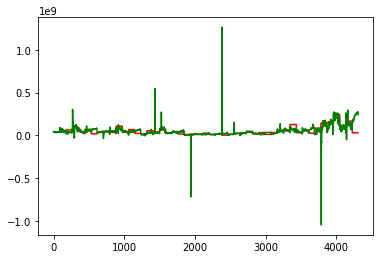

In [301]:
plt.plot(final_regional_no_outliers.DV, color='red')
plt.plot(final_regional_no_outliers.lasso_Pred, color='green')

# Final part: Combine model 1 and model 2

In [302]:
df = pd.read_csv('./df_cloud.csv', sep = ';', decimal=',', index_col=0)

df_mod1 = pd.read_csv('./cloud/model1/final_fc.csv', sep = ';', decimal=',', index_col=0).iloc[:,:7]
df_mod2 = pd.read_csv('./cloud/model2/final_fc_mod2.csv', sep = ';', decimal=',', index_col=0).iloc[:,:7]

df_mod2.columns = ['DATE', 'REGION', 'YEAR_QUARTER', 'DV', 'lr_Pred_mod2', 'lasso_Pred_mod2', 'rf_Pred_mod2']

In [303]:
df.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'PROFIT_CTR', 'OPEN_COMMIT_VAL',
       'OPEN_COMMIT_COUNT', 'OPEN_PROBABLE_VAL', 'OPEN_PROBABLE_COUNT',
       'OPEN_UPSIDE_VAL', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_VAL',
       'WB_COMMIT_COUNT', 'WB_PROBABLE_VAL', 'WB_PROBABLE_COUNT',
       'WB_UPSIDE_VAL', 'WB_UPSIDE_COUNT', 'VERBAL', 'ESTIMATED_IN', 'WON',
       'ADRM', 'BUDGET', 'REGION2', 'ACTUALS'],
      dtype='object')

In [304]:
df_final = pd.merge(df_mod1, df_mod2,
                   on=['DATE','REGION','YEAR_QUARTER'], how='inner')

df_final = pd.merge(df_final, df[['DATE','REGION','YEAR_QUARTER','ESTIMATED_IN','ACTUALS']],
                   on=['DATE','REGION','YEAR_QUARTER'], how='inner')

In [310]:
print(len(df_mod1))
df_mod1.head(1)

4409


,DATE,REGION,YEAR_QUARTER,DV2,lr_Pred,lasso_Pred,rf_Pred
0,2018-01-01,AP,2018-Q1,226397.03625,79247.893501,79247.895848,137261.360036


In [309]:
print(len(df_mod2))
df_mod2.head(1)

4409


,DATE,REGION,YEAR_QUARTER,DV,lr_Pred_mod2,lasso_Pred_mod2,rf_Pred_mod2
0,2018-01-01,AP,2018-Q1,3.925617e+07,2.961341e+07,2.485712e+07,4.034821e+07


In [308]:
print(len(df_final))
df_final.head(1)

4409


,DATE,REGION,YEAR_QUARTER,DV2,lr_Pred,lasso_Pred,rf_Pred,DV,lr_Pred_mod2,lasso_Pred_mod2,rf_Pred_mod2,ESTIMATED_IN,ACTUALS
0,2018-01-01,AP,2018-Q1,226397.03625,79247.893501,79247.895848,137261.360036,3.925617e+07,2.961341e+07,2.485712e+07,4.034821e+07,0.0,3.948256e+07


In [311]:
df_final['final_fc'] = df_final.ESTIMATED_IN + df_final.lasso_Pred + df_final.lasso_Pred_mod2 

df_final['MAPE_final_fc'] = abs(df_final.final_fc - df_final.ACTUALS) / df_final.ACTUALS 

In [312]:
df_final['MAPE_final_fc'].mean()

0.6580223008619165

# Finished here!!!

# residual forecasting part!!

In [85]:
train = df_residual[(df_residual.QuarterIndex != 7)]
holdout = df_residual[(df_residual.QuarterIndex == 7)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL']).reset_index()

In [86]:
'''features = df_residual.loc[: , 'LinearReg_Pred' : 'Delta_EstIn']

plt.figure(figsize=(15, 10))  
colnm = features.columns.tolist()
mcorr = features[colnm].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()'''

'features = df_residual.loc[: , \'LinearReg_Pred\' : \'Delta_EstIn\']\n\nplt.figure(figsize=(15, 10))  \ncolnm = features.columns.tolist()\nmcorr = features[colnm].corr(method="spearman")  \nmask = np.zeros_like(mcorr, dtype=np.bool)  \nmask[np.triu_indices_from(mask)] = True \ncmap = sns.diverging_palette(220, 10, as_cmap=True)  \ng = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt=\'0.2f\')  \nplt.show()'

In [87]:
train_x=train.loc[: , ['LassoReg_Pred', 'RF_Pred', 'ESTIMATED_IN', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling']]
train_y=train.res_rf

test_x=holdout.loc[: , ['LassoReg_Pred', 'RF_Pred', 'ESTIMATED_IN', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling']]
test_y=holdout.res_rf

In [88]:
y_pred_model1 = pd.DataFrame()


# Here I use the K-Fold validation set, but we can igore this step
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.15)

In [89]:
model_name = 'Linear'
model = linear_model.LinearRegression()
fit_intercept = [False]
param_grid = {'fit_intercept': fit_intercept}
LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
LinearReg_coef = LinearReg.coef_


model_name = 'Lasso'
model = Lasso()
fit_intercept = [False]
alph_range = np.arange(0.1,6,0.25)
param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LassoReg_coef = LassoReg.coef_
LassoReg_Pred = model_predict(LassoReg,test_x,test_y)

model_name = 'RandomForest'
model = RandomForestRegressor()
param_grid = {'n_estimators':[100,150,200],
              'min_samples_split':[2,4,6]
             }
RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

RF_Pred = model_predict(RF,test_x,test_y)

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4287273.5263640685, tolerance: 1703.9017714424936

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4377115.844295724, tolerance: 1641.5933216628969

/Users/i513088/anaconda

----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 1019.3530019505463
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 168.41088824215578
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4293611.190250507, tolerance: 1703.9017714424936

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4382908.899575108, tolerance: 1641.5933216628969

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405583.483121712, tolerance: 1692.7571251787697

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 871.3450188659216
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 236.39719930864896
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

In [90]:
result = pd.DataFrame({'SnapDate':holdout.SnapDate, 'GLOBAL_01_CODE':holdout.GLOBAL_01_CODE, 'CLOSING_QUARTER_ACTUAL':holdout.CLOSING_QUARTER_ACTUAL,
                       'test_y':holdout.test_y, 'RF_Pred':holdout.RF_Pred, 'res_rf':holdout.res_rf, 'fc_res_lr':LinearReg_Pred,'fc_res_lasso':LassoReg_Pred,'fc_res_rf':RF_Pred})

result['add_res_rf_lasso'] = result.RF_Pred + result.fc_res_lasso
result['mape_add_res_rf_lasso'] = abs(result.test_y - result.add_res_rf_lasso) / result.test_y


result['add_res_rf_lr'] = result.RF_Pred + result.fc_res_lr
result['mape_add_res_rf_lr'] = abs(result.test_y - result.add_res_rf_lr) / result.test_y


result['add_res_rf_rf'] = result.RF_Pred + result.fc_res_rf
result['mape_add_res_rf_rf'] = abs(result.test_y - result.add_res_rf_rf) / result.test_y


#result.to_csv('./res_q7new.csv', index = None, header=True, sep=';', decimal=',')

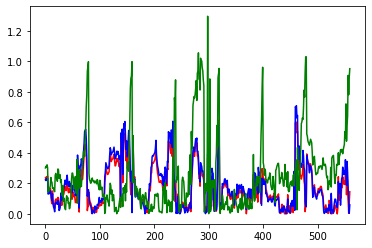

In [91]:
'''plt.plot(holdout.test_y, color='red')
plt.plot(holdout.RF_Pred, color='blue')
plt.plot(result.add_res_rf_lasso, color='green')
'''
#plt.plot(result.fc_res_lasso, color='blue')
#plt.plot(result.fc_res_rf, color='green')


plt.plot(result.mape_add_res_rf_lasso, color='red')
plt.plot(result.mape_add_res_rf_lr, color='blue')
plt.plot(result.mape_add_res_rf_rf, color='green')


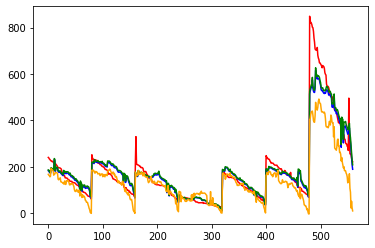

In [92]:
plt.plot(result.test_y, color='red')
plt.plot(result.add_res_rf_lasso, color='blue')
plt.plot(result.add_res_rf_lr, color='green')
plt.plot(result.add_res_rf_rf, color='orange')


In [96]:
result.columns

Index(['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'test_y',
       'RF_Pred', 'res_rf', 'fc_res_lr', 'fc_res_lasso', 'fc_res_rf',
       'add_res_rf_lasso', 'mape_add_res_rf_lasso', 'add_res_rf_lr',
       'mape_add_res_rf_lr', 'add_res_rf_rf', 'mape_add_res_rf_rf'],
      dtype='object')

In [97]:
#print(np.mean(abs(holdout.test_y-holdout.RF_Pred)/holdout.test_y))

print(np.mean(abs(result.test_y-result.RF_Pred)/result.test_y))

0.23881082788126853


In [94]:
print(np.mean(result.mape_add_res_rf_lr))
print(np.mean(result.mape_add_res_rf_lasso))
print(np.mean(result.mape_add_res_rf_rf))

0.1923711672194335
0.1705924589959723
0.25641322538520694


In [98]:
res_q1 = pd.read_csv('./res_q1.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q2 = pd.read_csv('./res_q2.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q3 = pd.read_csv('./res_q3.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q4 = pd.read_csv('./res_q4.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q5 = pd.read_csv('./res_q5.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q6 = pd.read_csv('./res_q6.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q7 = pd.read_csv('./res_q7.csv', sep = ';', decimal=',').reset_index(drop=True)

a = pd.concat([res_q1,res_q2,res_q3,res_q4,res_q5,res_q6,res_q7]).reset_index(drop=True)

In [100]:
a['add_res_rf_lr'] = a.RF_Pred + a.fc_res_lr
a['mape_add_res_rf_lr'] = abs(a.test_y - a.add_res_rf_lr) / a.test_y


a['add_res_rf_rf'] = a.RF_Pred + a.fc_res_rf
a['mape_add_res_rf_rf'] = abs(a.test_y - a.add_res_rf_rf) / a.test_y

In [102]:
a.to_csv('./final_fc_res.csv', sep = ';', decimal=',')
a.head(3)

,SnapDate,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,test_y,RF_Pred,res_rf,fc_res_lr,fc_res_lasso,fc_res_rf,add_res_rf_lasso,mape_add_res_rf_lasso,add_res_rf_lr,mape_add_res_rf_lr,add_res_rf_rf,mape_add_res_rf_rf
0,2018-01-01,AP,2018-Q1,226.37125,43.937276,182.433974,-33.485139,-33.517668,13.993321,10.419608,0.953971,10.452136,0.953827,57.930596,0.744090
1,2018-01-02,AP,2018-Q1,221.71285,43.937276,177.775574,-33.485139,-33.517668,13.993321,10.419608,0.953004,10.452136,0.952857,57.930596,0.738713
2,2018-01-03,AP,2018-Q1,209.63650,43.937276,165.699224,-33.485139,-33.517668,13.993321,10.419608,0.950297,10.452136,0.950142,57.930596,0.723662


In [104]:
print(np.mean(abs(a.test_y-a.RF_Pred)/a.test_y))
print(np.mean(a.mape_add_res_rf_lr))
print(np.mean(a.mape_add_res_rf_lasso))
print(np.mean(a.mape_add_res_rf_rf))

0.616173227644851
1.2412658521725348
1.0959631056987138
0.8432936822266037


In [112]:
mape = a.groupby(['GLOBAL_01_CODE','CLOSING_QUARTER_ACTUAL']).mean()
#mape = mape[['mape_add_res_rf_lasso', 'mape_add_res_rf_lr', 'mape_add_res_rf_rf']]
#mape.to_csv('./quarterly_MAPE_res.csv', sep = ';', decimal=',')

# <font color='red'>Baseline: normal vs residual visualization </font>

In [125]:
final_fc = pd.read_csv('./final_fc.csv', sep = ';', decimal=',',index_col=0).reset_index(drop=True)
final_fc_res = pd.read_csv('./final_fc_res.csv', sep = ';', decimal=',',index_col=0).reset_index(drop=True)
quarterly_MAPE = pd.read_csv('./quarterly_MAPE.csv', sep = ';', decimal=',').reset_index(drop=True)
quarterly_MAPE_res = pd.read_csv('./quarterly_MAPE_res.csv', sep = ';', decimal=',').reset_index(drop=True)

In [144]:
final_fc_result = pd.merge(final_fc[['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'test_y', 'LinearReg_Pred', 'LassoReg_Pred', 'RF_Pred']],
                            final_fc_res[['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL','add_res_rf_lasso', 'add_res_rf_lr', 'add_res_rf_rf']],
                           on=['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL'], how='inner')


#final_fc_result.to_csv('./final_fc_result.csv', sep = ';', decimal=',')


In [145]:
fincal_quarterly_MAPE = pd.merge(quarterly_MAPE[['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'MAPE_Lasso', 'MAPE_Lr', 'MAPE_RF']],
                            quarterly_MAPE_res[['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'mape_add_res_rf_lasso', 'mape_add_res_rf_lr', 'mape_add_res_rf_rf']],
                           on=['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL'], how='inner')

#fincal_quarterly_MAPE.to_csv('./fincal_quarterly_MAPE.csv', sep = ';', decimal=',')


In [152]:
final_fc_result = pd.read_csv('./final_fc_result.csv', sep = ';', decimal=',',index_col=0)
fincal_quarterly_MAPE = pd.read_csv('./fincal_quarterly_MAPE.csv', sep = ';', decimal=',',index_col=0)

In [153]:
final_fc_result.head(3)

,SnapDate,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,DV2,Linear,Lasso,RF,RF_res_lasso,RF_res_lr,RF_res_rf
0,01.01.18,AP,2018-Q1,226.37125,0.0,0.0,43.937276,10.419608,10.452136,57.930596
1,02.01.18,AP,2018-Q1,221.71285,0.0,0.0,43.937276,10.419608,10.452136,57.930596
2,03.01.18,AP,2018-Q1,209.63650,0.0,0.0,43.937276,10.419608,10.452136,57.930596


In [154]:
fincal_quarterly_MAPE.head(3)

,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,MAPE_Lasso,MAPE_Lr,MAPE_RF,MAPE_res_rf_lasso,MAPE_res_rf_lr,MAPE_res_rf_rf
0,AP,2018-Q1,1.372446,1.372440,0.975859,2.223550,2.341144,1.247194
1,AP,2018-Q2,0.362852,0.362841,0.267636,0.496096,0.513410,0.249725
2,AP,2018-Q3,0.988472,0.988463,0.311462,1.071914,1.094023,0.364805


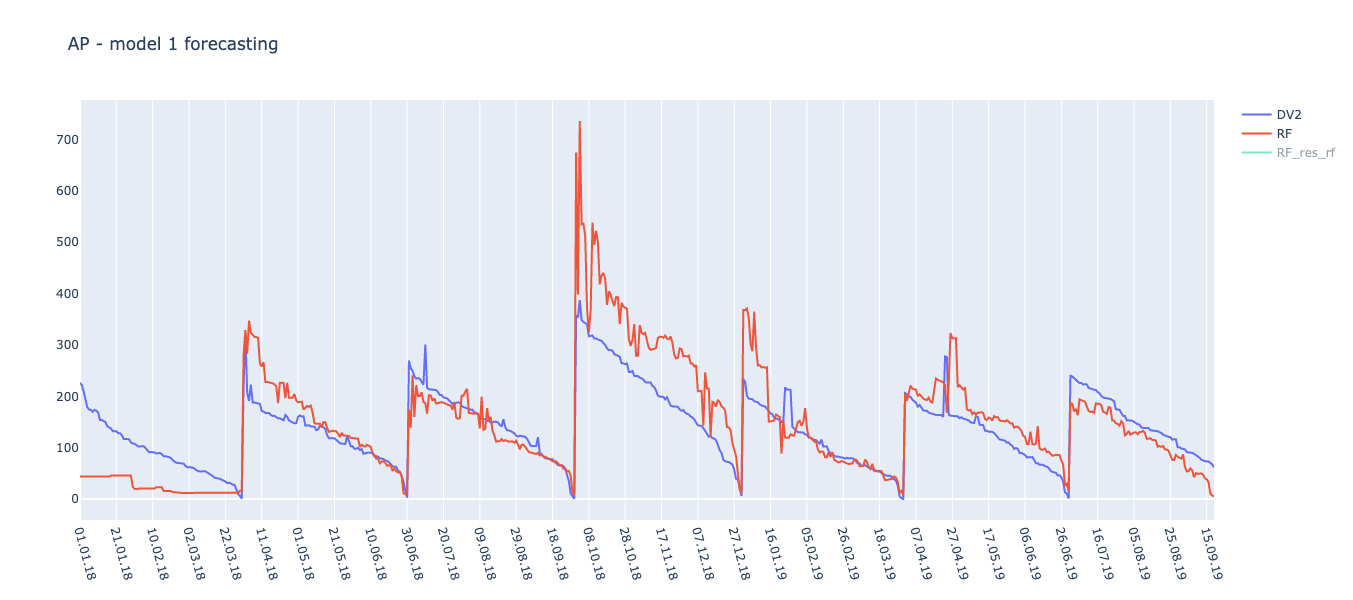

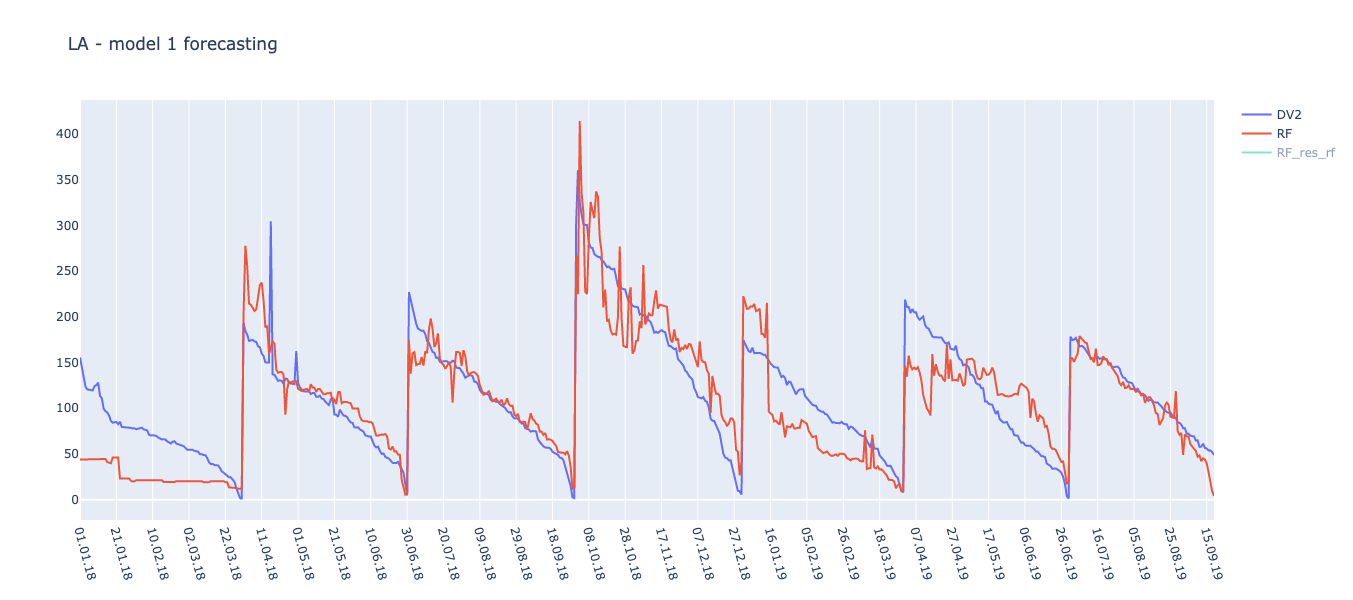

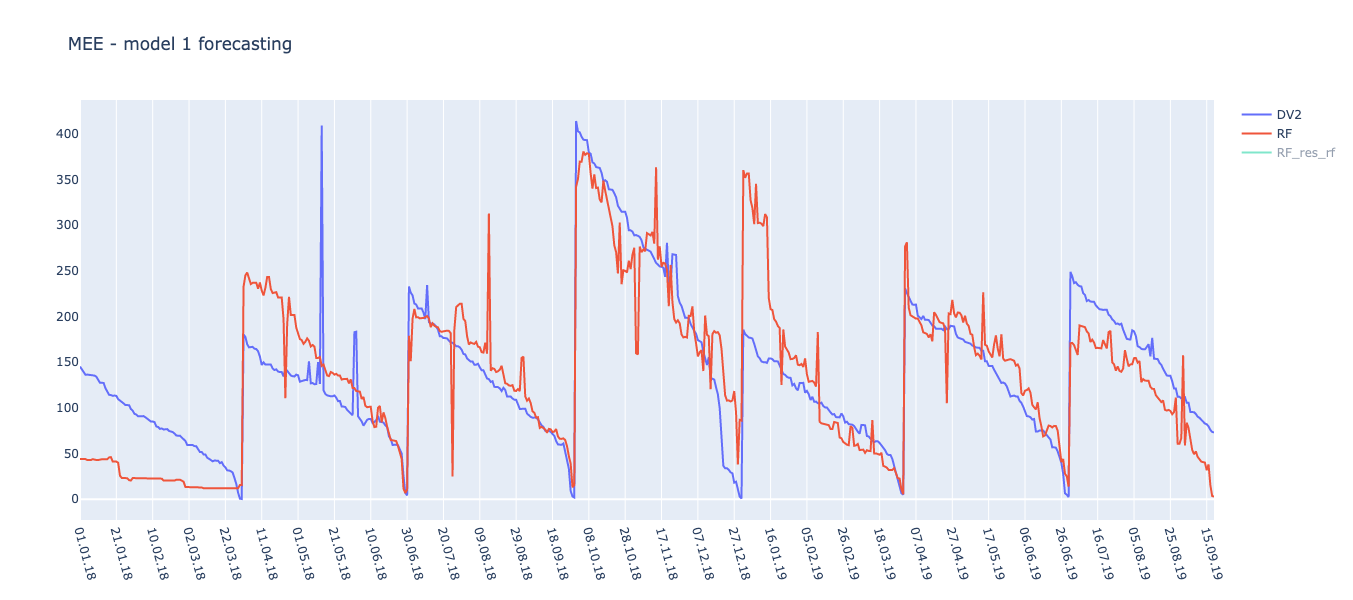

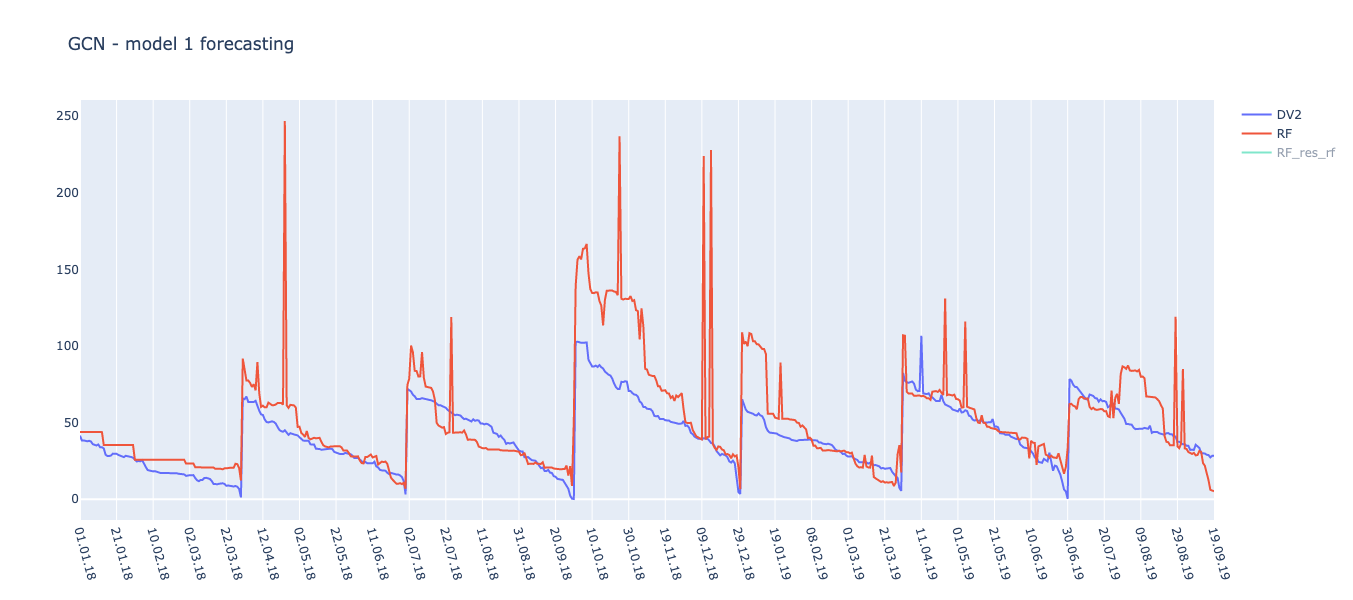

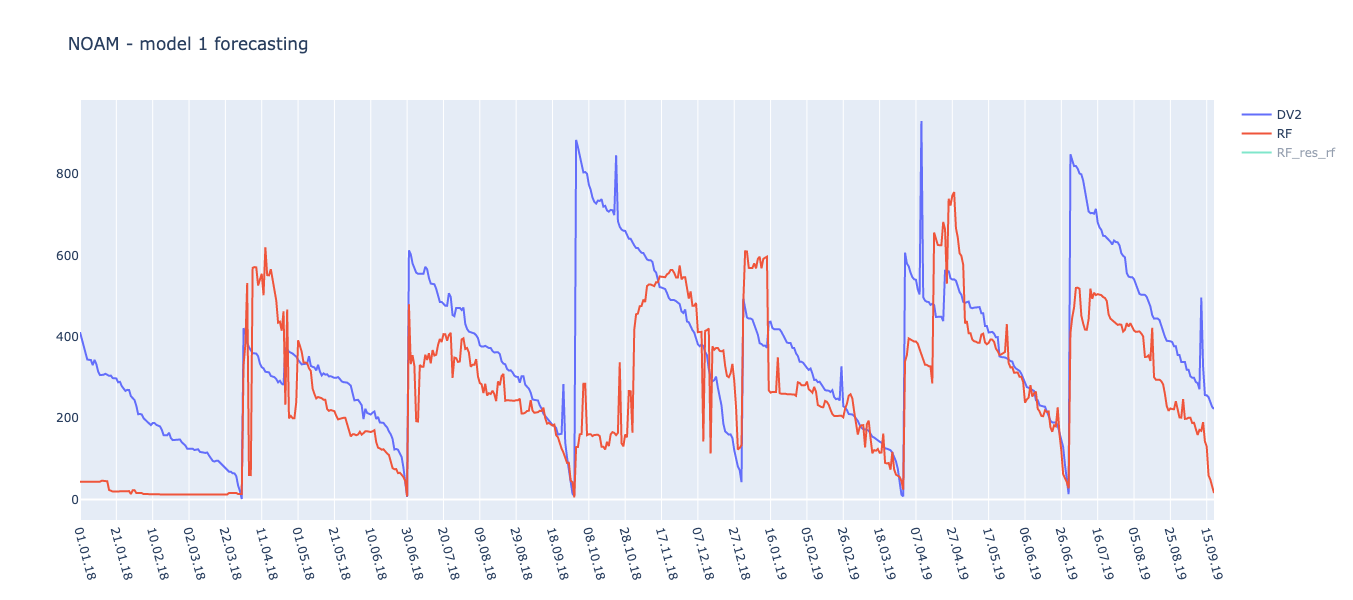

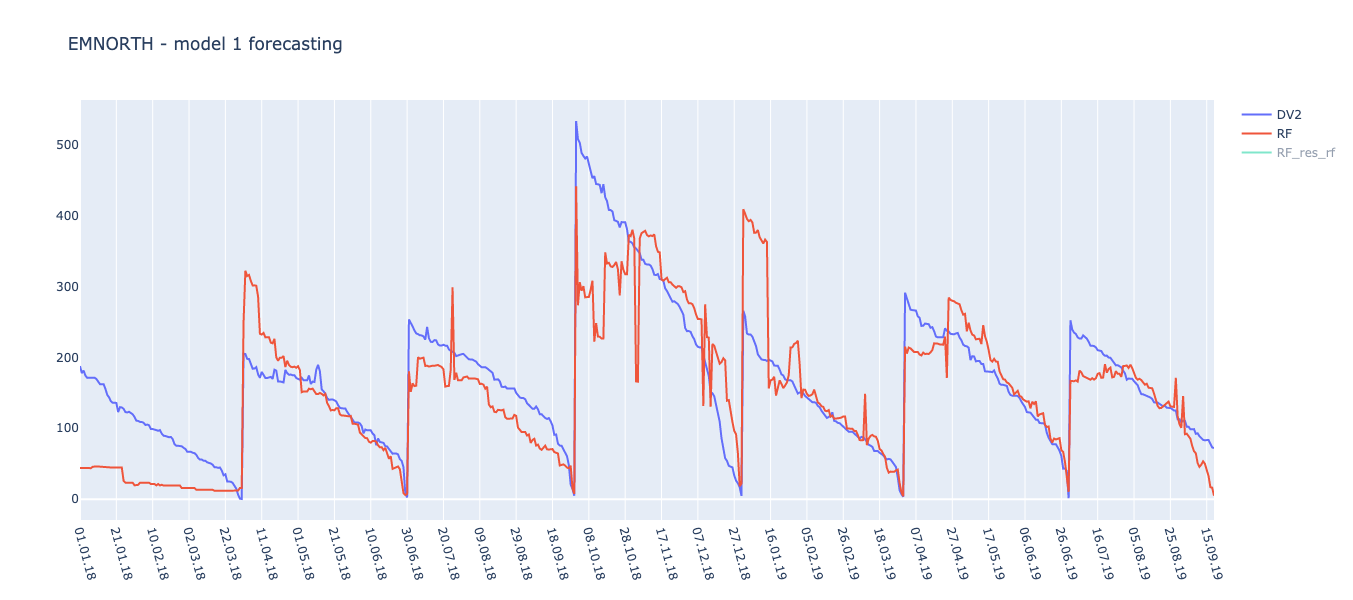

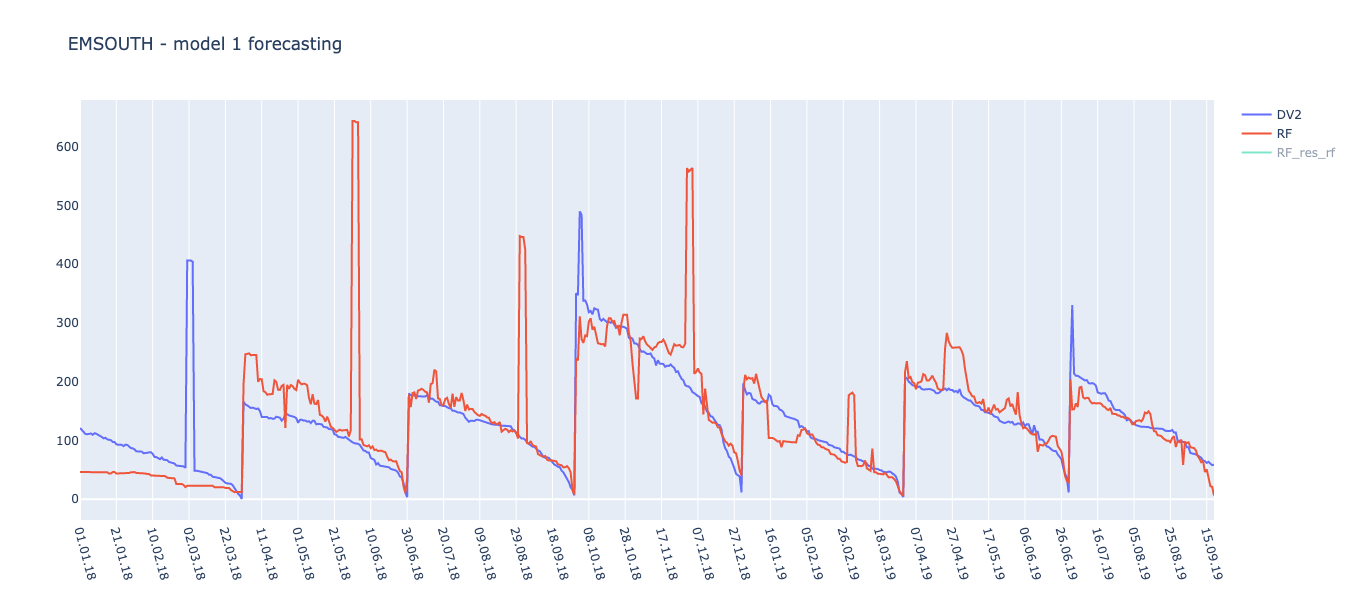

In [157]:
dataset = final_fc_result
compares = ['DV2','RF','RF_res_rf']   #['test_y','LassoReg_Pred', 'RF_Pred']
regions = ['AP','LA','MEE','GCN','NOAM','EMNORTH', 'EMSOUTH']
quarters = ['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3']
title_str = 'model 1 forecasting'

visulization(dataset, compares, regions, quarters, title_str)

In [179]:
dataset = fincal_quarterly_MAPE
compares = ['MAPE_Lasso', 'MAPE_RF', 'MAPE_res_rf_rf']   #['test_y','LassoReg_Pred', 'RF_Pred']
regions = ['AP','LA','MEE','GCN','NOAM','EMNORTH', 'EMSOUTH']
quarters = ['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3']
title_str = 'model 1 quarterly MAPE'

#visulization(dataset, compares, regions, quarters, title_str)

NameError: name 'fincal_quarterly_MAPE' is not defined

### MLP

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras import optimizers


batch_size = 50
epochs = 600
input_shape=(4,)
    
kf = KFold(n_splits=4, random_state=None, shuffle=True)

# Building the MLP model

model = Sequential()

model.reset_states() 
model.add(Dense(256,activation='linear',input_shape=input_shape))
#model.add(Dense(128,activation='relu',input_shape=input_shape))
#model.add(Dense(128,activation='linear'))
model.add(Dense(64,activation='linear'))
model.add(Dense(32,activation='linear'))
model.add(Dense(1,activation='linear'))


model.compile(loss='mae', optimizer=optimizers.Adagrad(lr=0.15, epsilon=None, decay=0.01))

model.summary()

for train_index, test_index in kf.split(train_x):
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    x_train, x_test = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]

    x_train = np.reshape(x_train,(len(x_train),4))
    x_test = np.reshape(x_test,(len(x_test),4))
    
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    
    model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test,y_test))



predicted_train = model.predict(train_x)
predicted_train = np.reshape(predicted_train, np.shape(train_y))
mape_train = np.mean(MAPE(train_y, predicted_train))


predicted_test = model.predict(test_x)
mlp_predicted_test = np.reshape(predicted_test, np.shape(test_y))
mape_test = np.mean(MAPE(mlp_predicted_test, test_y))


y_pred_model1['MLP'] = pd.Series(mlp_predicted_test)
    
y_pred_model1['MLP_mape'] = pd.Series(MAPE(mlp_predicted_test, test_y))
    
#y_pred_model1.to_csv('/Users/i513088/Desktop/y_pred_model1_count-Q5.csv')
    
    
#print('mae score_train:',score_train)
print('MAPE_train is: ', mape_train,'%')

#print('mae score_test:',score_test)
print('MAPE_test is: ', mape_test,'%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 19,841
Trainable params: 19,841
Non-trainable params: 0
_________________________________________________________________
MAPE_train is:  inf %


/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

divide by zero encountered in true_divide



NameError: name 'score_test' is not defined

In [158]:
#print('MAPE_train is: ', mape_train,'%')

#print('MAPE_test is: ', mape_test,'%')